# What are the common activities that the victims were engaged in prior to the accident?

In [149]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 23 15:12:27 2017

@author: leeto
"""
import os
import json
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
from nltk.util import ngrams
from nltk.tag.util import *
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import xlsxwriter

# List Of Category indexes as per stated in the CA document

In [150]:
CategoryIndexes = {"Caught in/between Objects":0,
                     "Falls":1,
                     "Drowning":2,
                     "Other":3,
                     "Others":3,
                     "Struck By Moving Objects":4,
                     "Collapse of object":5,
                     "Fires and Explosion":6,
                     "Electrocution":7,
                     "Suffocation":8,
                     "Exposure to Chemical Substances":9,
                     "Exposure to extreme temperatures":10,
                     }
CategoryNames = {0:"Caught in/between Objects",
                     1:"Falls",
                     2:"Drowning",
                     3:"Other",
                     4:"Struck By Moving Objects",
                     5:"Collapse of object",
                     6:"Fires and Explosion",
                     7:"Electrocution",
                     8:"Suffocation",
                     9:"Exposure to Chemical Substances",
                     10:"Exposure to extreme temperatures",
                     }

# Classes to store the category and case items together with helper functions

In [151]:
def GetCategoryIndex(Name):
    if Name in CategoryIndexes:
        return CategoryIndexes[Name]
    else:
        return -1
    
def GetCategoryName(Index):
    if (Index in CategoryNames):
        return CategoryNames[Index]
    else:
        return "Invalid Category"
        
#Classes To Be Used 
class Category(object):
    def __init__(self, Name, Index):
        self.Name = Name
        self.Index = Index
        self.ActivityTokensChunk = []
        self.ActivityTokensVerb = []
        
    def __str__(self):
        return("Category Item:\n"
               "  Name = {0}({1})\n"
               "  ActivityVerb = {2}\n"
               "  ActivityChunk = {3}\n"
               .format(self.Name, self.Index, str(len(self.ActivityTokensVerb)) , str(len(self.ActivityTokensChunk))))
        
class CaseItem(object):
    def __init__(self, Title, Summary, CauseName, CauseIndex):
        self.CauseName = CauseName
        self.CauseIndex = CauseIndex
        self.Title = Title
        self.Summary = Summary
        self.ActivityTokensChunk = []
        self.ActivityTokensVerb = []

    def __str__(self):
        return("Case Item:\n"
               "  Cause = {0}({1})\n"
               "  Title = {2}\n"
               "  Summary = {3}\n"
               .format(self.CauseName, self.CauseIndex, self.Title, self.Summary))

# Read from and write to excel, populate case items, intialization of categories

In [152]:
#read from excel, populate case items
def ReadFromExcelAndPopulateCase():
    global MsiaCaseItems 
    global OshaCaseItems
    global OshaCasesDF
    global MsiaCasesDF
    MsiaCaseItems = []
    OshaCaseItems = []
    MsiaCasesDF=pd.read_excel(MsiaCasesFile,sheetname=0)
    OshaCasesDF=pd.read_excel(OshaCasesFile,sheetname=0)
    MsiaCasesDF.groupby('Cause ').describe()
    # Note MsiaCases only summary case but Osha has description
    # For each row in the column,
    for index,row in MsiaCasesDF.iterrows():
        TempCaseItem = CaseItem(row['Title Case'], row['Summary Case'], row['Cause '], GetCategoryIndex(row['Cause ']))
        MsiaCaseItems.append(TempCaseItem)
    # For each row in the column, 
    for index,row in OshaCasesDF.iterrows():
        TempCaseItem = CaseItem(row['Title'], row['Description'], row['Cause'], GetCategoryIndex(row['Cause']))
        OshaCaseItems.append(TempCaseItem)

#Initialize Categories array
def InitializeCategories():
    global MsiaCategories
    global OshaCategories
    MsiaCategories = []
    OshaCategories = []
    for index in CategoryNames:
        tempcat = Category(GetCategoryName(index),index)
        MsiaCategories.append(tempcat)
        OshaCategories.append(tempcat)
        
def write_to_file(filename, text):
    f = open(filename, 'a')
    f.write(text + '\n')  # python will convert \n to os.linesep
    f.close()  # you can omit in most cases as the destructor will call it
    
def WriteToExcel(filename, SelectedCaseItemsDF):
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    # Convert the dataframe to an XlsxWriter Excel object.
    SelectedCaseItemsDF.to_excel(writer, sheet_name='Sheet1')
    # Close the Pandas Excel writer and output the Excel file.
    writer.save()    

# Visualisation function to plot frequency distribution, word cloud and list some of the common activities

In [153]:
# Visualisation function to plot frequency distribution, word cloud and list some of the common activities
def VisualisationAll(SelectedCases):   
    tokens_clean_single = []
    for item in SelectedCases:
        if (len(item.ActivityTokensVerb)>0):
            # frequecy distribution chart
            for tok1 in item.ActivityTokensVerb:
                tokens_clean_single.append(tok1)
    fd = nltk.FreqDist(tokens_clean_single)
    fd.most_common(25)
    TopActivityTokens = fd.most_common(5)
    fd.plot(25)
    print("Total count for this dataset is " + str(len(tokens_clean_single)))
    #print(tokens_clean_single)
    #print(TopActivityTokens)

    # ==== Installation of wordcloud package
    # 1. download wordcloud‑1.3.2‑cp36‑cp36m‑win_amd64.whl from http://www.lfd.uci.edu/~gohlke/pythonlibs/#wordcloud 
    # 2. Copy the file to your current working directory
    # 3. Open command prompt from Tools
    # 4. python -m pip install wordcloud-1.3.2-cp36-cp36m-win_amd64.whl

    # 1. Simple cloud
    # Generate a word cloud image
    # Take note that this function requires text string as input
    # text = "".join([' '+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()
    wc = WordCloud(background_color="white")
    wc.generate_from_frequencies(fd)
    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()    
    print("\n")

In [154]:
# Visualisation function to plot frequency distribution, word cloud and list some of the common activities
def Visualisation(category):   
    #tokens = word_tokenize(text)
    if (len(category.ActivityTokensVerb)>0):
        # frequecy distribution chart
        print(category.Name)
        #tokens_clean = [ t for t in category.ActivityTokensVerb if len(t) >= 3 ]
        tokens_clean_single = []
        for tok1 in category.ActivityTokensVerb:
            for tok2 in tok1:
                tokens_clean_single.append(tok2)
        fd = nltk.FreqDist(tokens_clean_single)
        fd.most_common(25)
        TopActivityTokens = fd.most_common(5)
        fd.plot(25)
        print("Total count for this category is " + str(len(tokens_clean_single)))
        #print(tokens_clean_single)
        #print(TopActivityTokens)
        
        # ==== Installation of wordcloud package
        # 1. download wordcloud‑1.3.2‑cp36‑cp36m‑win_amd64.whl from http://www.lfd.uci.edu/~gohlke/pythonlibs/#wordcloud 
        # 2. Copy the file to your current working directory
        # 3. Open command prompt from Tools
        # 4. python -m pip install wordcloud-1.3.2-cp36-cp36m-win_amd64.whl
    
        # 1. Simple cloud
        # Generate a word cloud image
        # Take note that this function requires text string as input
        # text = "".join([' '+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()
        wc = WordCloud(background_color="white")
        wc.generate_from_frequencies(fd)
        # Display the generated image:
        # the matplotlib way:
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()    
        
        chunks_limit = 10
        print("Top 5 activity word and their sentences")
        print("=======================================\n")
        for word in TopActivityTokens:
            chunks_count = 0
            underline = ""
            print('\n' + word[0])
            for c in word[0]:
                underline += '='
            print(underline + '\n')
            #Populate sentences belonging to top tokens
            for chunk1 in category.ActivityTokensChunk:
                for chunk2 in chunk1:
                    chunk_token = nltk.sent_tokenize(chunk2)
                    chunk_lemma_token = get_lemma(chunk_token)
                    #print(chunk_lemma_token)
                    #chunk_text = ' '.join(chunk)
                    if len(chunk_lemma_token) >= 1:
                        #print (chunk_lemma_token)
                        for token in chunk_lemma_token:
                            if word[0] in get_lemma_word(token.split(' ')[0]):
                                if (chunks_count < 10):
                                    print(chunk2)
                                chunks_count += 1

            print("\n")
    else:
        print("Visualisation Function : NO DATA AVAILABLE")



# Text Mining helper functions 
- get_lemma - lemmatizer to get the base word based on speech tag
- get_stem - similar to get_lemma but some of the base words are not correct, so I did not use this
- get_verb_count - returns number of verb word found in the sentence
- filter_off_unwanted chunks - custom filter to more accurately extract verb associated with the activities

In [155]:
def get_lemma(subtree):        
    return [ WNlemma.lemmatize(t, 'v') for t in subtree ]

def get_lemma_word(text):
    return WNlemma.lemmatize(text, 'v')

def get_stem(subtree):
    return [ Stemmer.stem(t) for t in subtree ]

def get_verb_count(subtree):
    verb_count = 0
    tokens = nltk.pos_tag(word_tokenize(str(subtree))) 
    for tok in tokens:
        if ('\'VBG\'' in str(tok)) or ('\'VB\'' in str(tok)):
            verb_count += 1
    return verb_count

def filter_off_unwanted_chunks(subtree):
    # first words : crashing, causing, involving, doing, being, falling
    filter_first_words = ['crash', 'cause', 'involve', 'do', 'be', 'fall', 'avoid', 'result', 'address', 'have', 'wear', 'use', 'work', 'exist', 'remain', 'include', 'experience','come','contain']
    filter_all_words = ['carry out work', 'fly object']
    filter_last_words = ['victim', 'work']
    filter_short_words = ['kill','carry', 'perform']   
    for ffw in filter_first_words:
        if (ffw in get_lemma(untag(subtree))[0]):
            return False, subtree
    for flw in filter_last_words:
        if (flw in get_lemma(untag(subtree))[len(subtree)-1]):
            return False, subtree
    for fsw in filter_short_words:
        if ( fsw in ' '.join(get_lemma(untag(subtree))) and (len(subtree)<=2) ):
            return False,subtree
    for faw in filter_all_words:
        if ( faw in ' '.join(get_lemma(untag(subtree))) ):
            print (faw)
            return False, subtree
    if get_verb_count(untag(subtree)) > 0:  
        return True, subtree
    else: 
        return False, subtree

def clean_up_chunk(text):
    text = text.replace("carri", "carry")
    text = text.replace("[","").replace("]","").replace("\'","").replace("\"","")
    text = text.replace("\'","").replace("\"","").replace(",","")
    return text

def clean_up_verb(text):
    text = text.replace("carri", "carry")
    text = text.replace("[","").replace("]","").replace("\'","").replace("\"","")
    text = text.replace("\'","").replace("\"","").replace(",","")
    text = text.replace(' ','')
    return text

# Main function to extract the activities sentences and verb
- 1st loop (ie. OCC1) is used for extracting the sentences containing the activities. The RegexpParser will look for verb in past tenses(VBD), base form(VB), past participle(VBN), present participle(VBG) etc that is constructed together with nouns(singular, plural, proper noun,) as well as preposition(IN), adjective(JJ), particle(PR).

- 2nd loop (ie. OCC2) is used to further extract the base verb that is found using OCC1.

In [156]:
def extract_activities_chunk_and_verb(text):
    chunk_grammar = r"""
        OCC1:{<VBG|VB>+<IN|DT|JJ|RP>*<NN|NN.*>+(<IN|DT|JJ|RP>*<VBG|VB>+<NN|NN.*>+)?}
    """

    verb_grammar = r"""
        OCC2:{<VBG|VB>+}
    """    
#   original OCC:{<VBG|VB>+<IN|DT|JJ|RP>?<NN|NN.*>+<VBG|VB>?}
    ExtractedActivitiesChunk = []
    ExtractedActivitiesVerb = []
    if (not text=="") and (len(text) >= 3):
        chunk_parser = nltk.RegexpParser(chunk_grammar)
        tokens_chunk = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
        tagged_chunk = nltk.pos_tag(tokens_chunk)
        if (len(tagged_chunk) > 0):
            extract_chunk = chunk_parser.parse(tagged_chunk)
            for subtree_chunk in extract_chunk.subtrees(filter=lambda t: 'OCC1' in t.label()):  
                acceptChunk, processed_subtree_chunk = filter_off_unwanted_chunks(subtree_chunk)
                if (acceptChunk == True):
                    token_chunk_clean = untag(processed_subtree_chunk)
                    #token_chunk_clean_str = clean_up_chunk(str(get_lemma(token_chunk_clean)))
                    token_chunk_clean_str = clean_up_chunk(str(token_chunk_clean))
                    print(token_chunk_clean_str + "(" + str(get_verb_count(untag(processed_subtree_chunk))) + ")")
                    ExtractedActivitiesChunk.append(token_chunk_clean_str)
                    verb_parser = nltk.RegexpParser(verb_grammar)
                    tokens_verb = [word for sent in nltk.sent_tokenize(token_chunk_clean_str) for word in nltk.word_tokenize(sent)]
                    tagged_verb = nltk.pos_tag(tokens_verb)
                    if (len(tagged_verb) > 0):
                        extract_verbs = verb_parser.parse(tagged_verb)
                        for subtree_verb in extract_verbs.subtrees(filter=lambda t: 'OCC2' in t.label()):  
                            #print(subtree_verb)
                            tokens_verb_lem = get_lemma(untag(subtree_verb))   
                            tokens_verb_lem_clean = clean_up_verb(str(tokens_verb_lem))
                            #print(tokens_verb_lem_clean)
                            ExtractedActivitiesVerb.append(clean_up_verb(str(tokens_verb_lem_clean)))
    return ExtractedActivitiesChunk, ExtractedActivitiesVerb

# Main Loop
- Initializes the case and categories item
- create the lemmatizer and stemmer objects
- read from excel and populate the case and categories

In [157]:
# Initialize     
MsiaCategories = []
MsiaCaseItems = []
MsiaCasesDF = []
OshaCategories = []
OshaCaseItems = []
OshaCasesDF = []

MsiaCasesFile = 'MsiaAccidentCases.xlsx'
#the Osha case file must have the causes populated by the predictor model developed by Vincent
OshaCasesFile = 'osha1.xlsx'

#NLTK Objects
# lemmatize to convert to base words depending on speech tagging
WNlemma = nltk.WordNetLemmatizer()
# stemmer to get the base words
Stemmer = nltk.SnowballStemmer('english')   

#Initilize categories
InitializeCategories()
#Read data from excel and populate case items
ReadFromExcelAndPopulateCase()

# Flags to determine which data set to use. 
- ProcessMsiaDataSet for Msia Dataset
- ProcessOshaDataSet for Osha Dataset

In [158]:
# if False, means process the Osha dataset
ProcessMsiaDataSet = True
ProcessOshaDataSet = False

# Main Processing Section 1
- Loops through each case item then populate the activities sentences and verb token 

In [159]:
if ProcessMsiaDataSet:
    #Populate Activity Tokens for CaseItems and Categories
    for caseitem in MsiaCaseItems:
        caseitem.ActivityTokensChunk,caseitem.ActivityTokensVerb = extract_activities_chunk_and_verb(str(caseitem.Summary))
        for cat in MsiaCategories:
            if int(caseitem.CauseIndex) == int(cat.Index):
                cat.ActivityTokensVerb.append(caseitem.ActivityTokensVerb)
                cat.ActivityTokensChunk.append(caseitem.ActivityTokensChunk)

installing wood plate(1)
carrying the job of binding Reinforcement Steel Cage(2)
climbing up the cage(1)
performing cable pulling job(2)
opening the clutch door(1)
dismantling Shear Wall(1)
carry out work
controlling the traffic(1)
entering the room(1)
move the box containing foods(1)
moving forklift(1)
carrying mold installation(1)
stepping on the hollow section(1)
replacing the bricks(1)
wrapping plastic tubing(2)
breaking the stone(1)
lying on the floor(1)
cutting down trees(1)
lifting a bundle(1)
cutting down trees(1)
lifting a pile(1)
lift the lifting tray(1)
removing the glass door(1)
tagging the name(1)
standing on plywood plate(1)
carry out binding(1)
lifting lug(1)
lifting works using Overhead Travelling Crane(3)
cutting the oil palm fruit(1)
knitting the oil palm fruits(1)
driving mechanical buffalo(1)
dismantling the top structure(1)
climbing the scaffolding(2)
driving downhill(1)
standing on the drawbar trailer(1)
lifting the drain block(1)
carrying road leveling work using

In [142]:
if ProcessOshaDataSet:
    #Populate Activity Tokens for CaseItems and Categories
    for caseitem in OshaCaseItems:
        caseitem.ActivityTokensChunk,caseitem.ActivityTokensVerb = extract_activities_chunk_and_verb(str(caseitem.Summary))
        for cat in OshaCategories:
            if int(caseitem.CauseIndex) == int(cat.Index):
                cat.ActivityTokensVerb.append(caseitem.ActivityTokensVerb)
                cat.ActivityTokensChunk.append(caseitem.ActivityTokensChunk)

operating a forklift(1)
moving bales(1)
replacing an air filter(1)
specializing in fiber(1)
marking the location(1)
performing the duties(1)
travelling in the travel/through lane(1)
offloading hot brine water(1)
switching the truck(1)
let go causing the hot brine water(1)
running toward the control room(1)
transferring soup(1)
cutting the seal(1)
pulling a knife(1)
placing on the knife(1)
stabbing type(1)
operating a rough terrain forklift(1)
positioning the forklift(1)
pulling a cart(1)
making turns(1)
turning cart(1)
installing vinyl sidings(1)
standing an A-frame ladder(1)
Using the table(1)
ripping the piece(1)
ripping the second board Employee(1)
cutting a third piece(1)
alleging violation(1)
ripping pieces(1)
transferring product(1)
operating an asphalt-pulverizing machine(2)
cleaning the interior(1)
standing in front(1)
inspecting the 21000-volt pad(1)
idling Caterpillar D8K track bulldozer(1)
lowering the unit(1)
kneeling on the bulldozer(1)
insert nails into roofing tiles(1)
w

performing restoration efforts(1)
sitting on a toilet seat cover applying Sunrez resin(2)
detailing a boat(1)
cleaning with acetone(1)
coating WC powder(1)
welding a shaft(1)
welding torch(1)
testing the controls(1)
reaching into the bilge opening(2)
cleaning a spray booth(1)
purging the paint lines(1)
peeling the coating(2)
leaning against some boxes(1)
manufacturing facility(1)
removing the old tile(1)
removing old adhesive(1)
scrubbing the floor(1)
removing safety brackets(1)
supporting the trellis(1)
connecting the trellis(1)
connecting the trellis(1)
cutting a pipe(1)
cutting the well(1)
casing igniting an unknown substance(2)
cutting the well casing(2)
welding gloves(1)
break the concrete lining(1)
separating the pipe(1)
sling hooks(1)
sustaining severe injuries(1)
removing the roof(1)
cutting torch(1)
sorting out different types(1)
turning on the acetylene(1)
adjusting the torch(1)
connecting the hose(1)
cutting torch(1)
burning both men(1)
cutting torch(1)
lowering the lift(1)


monitoring the automated line(1)
replacing the guard(1)
making repairs(1)
rotating air lock veins(1)
operating a Bliss OBI(1)
making lightweight washers(1)
blowing the parts(1)
releasing the pressure(1)
checking the part(1)
reattaching the air lines(1)
operating a Taurus CNC machine(1)
running a program(1)
removing the carbon dust(1)
rotating bit(1)
exsanguinating intra-abdominal hemorrhage(1)
unloading a trailer(1)
contributing causal factor(1)
handling facility(1)
repairing a leak(1)
pruning the tops(1)
telescoping in a design(1)
remove the jammed material from the pruning head(1)
amputating the tip(1)
disassembling the facility(1)
holding this unit(1)
performing a brake work on paving truck Number(2)
replacing the first air line(1)
ringing in both ears(1)
inflating a tire(1)
releasing chlorine(1)
leaving the plant(1)
breathing air(1)
attaching the airlines(1)
crushing injuries(1)
specializing in building docks(2)
installing fender panels(1)
protruding portion(1)
striking the water(1

contracting company(1)
driving the service truck(1)
checking the loading ramp(2)
making sure that Employee(1)
gathering the materials(1)
receiving a call(1)
facing the warehouse(1)
retrieving a tool(1)
maintaining the traffic pattern(1)
retaining wall(1)
backing up the milling machine(2)
driving lane(1)
back the milling machine(1)
passing lane(1)
transiting the facility(1)
walking across the new roadway(1)
paving machine(1)
operating a New Holland(1)
traveling in reverse(1)
standing in the path(1)
spraying water(1)
opening the nozzle bale(1)
performing landscape maintenance(1)
operating a weed-eater(1)
driving under the influence(1)
landing coming down the marble stairs(2)
staying at the hotel(1)
jumping from the front(1)
utilizing a high-pressure water hose(1)
loading tobacco(1)
missing person(1)
drinking beer(1)
directing traffic(1)
lighting traffic signs(1)
traveling southbound(1)
programming the transmitters(1)
treating inmates(1)
tipping the drum(1)
spilling alcohol(1)
grinding a 

installing window trim(1)
According Employee(1)
hanging onto the gutter(1)
erecting a grain leg(1)
adjusting the come-a-long in a forward motion(1)
paving company(1)
relocating a guy(1)
sustaining entry wounds(1)
installing roof decking(2)
allowing the employee(1)
moving logs(1)
gripping at the hoist(1)
standing inside the bight(1)
installing wire mesh(1)
installing lathing(2)
sitting down on the floor(1)
operating a Makita(1)
setting up chairs(1)
grading foreman(1)
watering various trees(1)
sustaining an aneurysm(1)
lying beside a concrete mixer truck(1)
attending physician(1)
arriving at the scene Employee(1)
suffering a heart attack(1)
performing routine checks(1)
leading from the tank(1)
leaking ammonia(1)
repositioning an adjustable scaffold(1)
releasing ammonia vapors(1)
removing an anhydrous ammonia tank(1)
standing behind Employee(1)
entering the corridor Employee(1)
filling a nurse tank(1)
lying on the ground(1)
disconnecting the hose(1)
filling the nurse tank Employee(1)
hook

driving the scraper(1)
testing during the inspection(2)
performing all maintenance(1)
tuning the engines(1)
sitting on top(1)
removing asbestos(1)
rolling scaffold(1)
sustaining a small laceration(1)
hitting a piece(1)
removing asbestos(1)
removing asbestos(1)
clearing access(1)
standing at the base(1)
tearing down the brick doors(1)
settling chamber(1)
operating the Brock(1)
shoveling while the conveyer(1)
shoveling fly ash(1)
contemplating wetting the fly(2)
moving conveyer flight(1)
directing the first driver(1)
Paling Trucking with a dump load(2)
standing on the ground(1)
standing near the rear driver(1)
burning wood waste(1)
cleaning the material(1)
standing on a ladder(1)
cleaning fly ash(1)
dislodging ash(1)
clearing a large mass(1)
opening burning Employees(2)
flowing through the duct(1)
enveloping everyone(1)
evacuating the area(1)
walking in ashes(1)
holding the nozzle(1)
directing the water stream(1)
holding the hosepipe(1)
operating a Case skid steer loader(1)
raise a hoppe

spraying a fire retardant(1)
dumping the fire(1)
pushing some of the material(1)
sanitizing a dough mixer(1)
sanitizing the dough mixer(1)
entering the dough mixer(1)
taping the plastic cover(1)
ring fingers(1)
unclogging the Pomace Incline Conveyor line(1)
clearing a jam(1)
crushing injuries(1)
cleaning a meat tenderizer machine(1)
ring fingers(1)
disconnecting the cord(1)
performing sanitation activities(1)
slicing line(1)
cutting product process(1)
slicing machine(1)
shut down the process line for cutting paper(1)
putting bacon(1)
setting up operations(1)
placing the left gear(1)
ring finger(1)
folding a carton plant(1)
setting up operations(1)
moving components(1)
repairing the problem(1)
adjusting the sensor(1)
opening a relay switch(1)
completing the repair(1)
ring finger(1)
assessing a problem(1)
loading arm(1)
loading a wrecked car(1)
standing at the hoist controls(1)
operating a trim press(1)
reset a spring(1)
reaching in the machine(1)
performing machine adjustments(1)
contri

walking on the grounds(1)
harvesting peaches(1)
unloading pallets(1)
shipping doors(1)
bring the dock stopper(1)
changing direction(1)
reversing forklift(1)
driving a garbage truck(1)
recycling company(1)
recycling company(1)
wrecking truck company(1)
standing on the right rear side(1)
directing the wrecker(1)
loading mechanism(1)
watching Employee(1)
tying down a tarp(1)
moving a bob cat(1)
loading dock(1)
loading dock area(1)
walking down the catwalk(1)
handling system(1)
handling system(1)
repairing the conveyor(1)
bagging feed corn(1)
standing against the bagging machine(2)
leaving Gate Number(1)
finishing the job of loading baggage(2)
standing on a passenger seat(1)
inspecting moving parts(2)
steering wheel(1)
serving as a crew leader(1)
off-loading inbound flight Number(1)
pushing the load(1)
holding the lock(1)
placing a luggage container(1)
crushing injuries(1)
moving belt(1)
crushing injuries(1)
driving an aircraft belt loader(1)
trapping Employee(1)
walking out of the bag roo

extinguishing the fire(1)
lighting strike(1)
cutting torch(1)
connecting piping a metal stairway(2)
operating an overhead gantry hoist crane(1)
charging station(1)
lifting a battery(1)
lifting beam(1)
missing from the same end(1)
slipping out of the battery eyelet(1)
unplugging a 480-volt drop cord(1)
unplugging the cord(1)
charging a forklift battery(1)
ejecting acid(1)
riding pallet jack(1)
riding pallet jack(1)
pinning Employee(1)
charging station(1)
driving a stand-up electric forklift(1)
charging unit(1)
leaning against an air compressor tank(1)
installing equipment(1)
leaning on a live battery charger(1)
charging the batteries(1)
flying pieces(1)
starting the ignition(1)
starting the buses(1)
starting battery(1)
charging all night(1)
opening the unit(1)
ventilate the battery-holding chamber(1)
siphoning gasoline(1)
igniting flammable vapors(1)
sending flames(1)
burning Employee(1)
approaching the angle iron barrier(1)
charging station(1)
turning the right rotating hand grip upwar

operating a bladder-type forming machine(2)
loading paper rolls(1)
installing a new bathroom countertop(1)
cutting the sink hole(1)
standing facing the jointer(2)
functioning at the time(1)
moving blade(1)
clearing a jam(1)
rotating blades(1)
shaping a bush(1)
facing the bush(1)
shearing action(1)
repairing railroad freight car load dividers(1)
standing on the bulkhead(1)
pinning Employee(1)
driving a high-lift forklift truck(1)
lowering a chain(1)
lowering the chain(1)
running Employee(1)
hanging from the forks(1)
controlling levers(1)
pinning Employee(1)
demonstrating the proper removal(1)
descending the tree(1)
warning the employee(1)
waiting for the ambulance(1)
testing the integrity(1)
installing concrete traffic barriers(1)
setting K-rails(1)
operating a National crane Model N-135(1)
overloading the crane(1)
advancing the stock(1)
rotating blade(1)
grinding a food product(1)
turning the machine(1)
sealing surface(1)
moving blade rotates(1)
slicing lamb lungs(1)
cutting lamb lungs

flashing material(1)
stacking an order(1)
cutting straps(1)
cutting the straps Employee(1)
transferring a product(1)
transferring the product(1)
clean out the docking leveres(1)
lifting the docking lever plate(2)
placing the prop(1)
striking Employee(1)
setting the prop(1)
sanding a cabin door(1)
floating dock housing(2)
making a delivery(1)
operating a tug(1)
suffering a broken neck(1)
operating a Shuttlewagon SWX415B(1)
moving railcar(1)
handing out small recreational boats(1)
signaling the crane(1)
fabricating a new dredge boat(1)
painting inside the first pontoon compartment(1)
nearing completion(1)
painting this compartment(1)
dismantling a scaffold(1)
rigging cable using test(2)
striking Employee(1)
driving a customer(1)
travelling at wide open throttle the boat(1)
inspecting a piece(1)
reinstalling a metal(1)
welding vapors(1)
rotating spindle(1)
rotating the spindle(1)
unwinding the yarn onto the rotating metal(2)
roving machine(1)
standing at a wire rope(1)
cutting torch(1)
re

painting the inside(1)
installing the sixth panel(1)
washing windows(1)
spanning North Sierra Street(1)
descending the tree(1)
climbing rope(1)
climbing saddle(1)
driving a Ford F550(1)
depending on the size(1)
rolling down the sloped deflection plate(1)
turning the large boulder(1)
installing a drainage system(1)
operating a double-roller(1)
remove a large stuck boulder between operating conveyor belt(1)
digging holes(1)
facing a dam(1)
removing a boulder(1)
fighting a blaze(1)
supervising the installation(1)
shoring along the south wall(1)
protruding rock(1)
protruding rock(1)
shoring support system(1)
rolling down from a spur road(1)
breaking the rock(1)
standing on an adjacent boulder(1)
standing on the trail(1)
laying a French drain(1)
digging a hole(1)
clearing trails(1)
waiting for the cast skidder(1)
preparing a road bed(1)
crushing Employee(1)
replacing the parts(1)
cleaning the equipment(1)
setting machine(1)
tagging out the equipment(1)
setting bed(1)
setting bed(1)
clearing

operating a brick cutter(1)
lying under the brick cutter(1)
rotating hydraulic arm(1)
operating the setting machine(2)
cleaning out pieces(1)
lying on the table(1)
setting the machine(1)
fool the machine by hanging weights(1)
performing this procedure(1)
catching Employee(1)
operating machine(1)
guarding devices(1)
looking in the direction(1)
operating a DitchWitch SK350 rubber(1)
standing on the skid steer(1)
pouring concrete(1)
making preparations(1)
securing the area(1)
lying unresponsive on the catch net(1)
lighting during shotcrete application(2)
backing up the track(1)
instaling a metal chanel(1)
suffering from multiple injuries(1)
rigging for tarps(1)
moving a 36-foot guardrail section(1)
covering several acres(1)
removing pieces(1)
standing on a work platform(1)
operating a bridge crane(1)
removing tension(1)
standing on the steel plate(1)
placing a plywood screen(1)
placing bridge girders(1)
positioning the aerial lift(1)
landing beams(1)
operating a spiral machine(1)
running 

feeding brush(1)
placing tree limbs(1)
trimming trees(1)
feeding brush(1)
cutting a limb(1)
cutting the limb(1)
cutting clean through the stalling(2)
holding wood(1)
swing down in an arc(1)
operating a Morbark Hurricane wood chipper(1)
reverse the feeding wheel(1)
supervising women(1)
cutting brush(1)
Following the second set(1)
providing directions(1)
sawing brush(1)
operating the chain(1)
trimming trees(1)
feeding a freshly cut eucalyptus(1)
adjusting the chipper(1)
feeding a large tree limb(1)
clearing the right-of-way(1)
operating a chipper(1)
bringing the branches(1)
removing the accumulation(1)
spinning blade(1)
bolting down the blade(1)
missing exposing the spinning blade(3)
preventing the use(1)
missing safety device(1)
shredding blade(1)
feeding brush(1)
hear the warning shouts(1)
assisting another employee(1)
lying on the ground(1)
jerk throwing the employee(1)
hitting the ground(1)
surrounding the lake(1)
operating the loader(1)
resting on a grade(1)
rolling Employee(1)
adju

parking brake safety feature(1)
raising the truck(1)
supporting the truck(1)
lowering vehicle(1)
raising rear suspension components(1)
driving a Wolfline bus(1)
tapping down the amperage(1)
removing locking pins(2)
locking pin(1)
locking pin(1)
locking pin(1)
plowing around the bus building(2)
lying face(1)
facing toward the interior(1)
securing the bus(1)
removing a bottle jack(1)
transiting across the parking lot(2)
pulling into the parking lot(2)
raining throughout the day(1)
descending industrial stairs(1)
walking in the parking lot(2)
walking in the parking lot Employee(2)
replacing a leaf spring(2)
bushing on a school bus(1)
inserting a pin(1)
preventing the pin(1)
assisting in the separation(1)
connecting the vehicle body(1)
Using a Caterpillar loader Model Number(1)
hindering the separation(1)
striking Employee(1)
inspecting a bus(1)
running during the inspection(2)
parking brake(1)
show anything(2)
servicing the electrical substation(1)
installing wiring for control relays(2)


servicing a sump pump(1)
placing the cover(1)
touching the housing(2)
installing a 120-volt squirrel-cage fan(1)
reconnecting the first phase conductor(1)
testing following a fault(2)
testing equipment(1)
troubleshooting a commercial microwave(1)
performing this job(1)
tagging program(1)
troubleshooting an air conditioner(1)
Kneeling on damp ground(1)
resting against the grounded case(1)
burning smell(1)
utilizing equipment(1)
removing outside man-way covers(1)
entering the freezer unit(1)
assist believing that Employee(1)
testing over several days(1)
driving a Ford Transit Connect(1)
traveling Holt Blvd(1)
arriving at the site members(1)
missing for over an hour(1)
summoning emergency services(1)
traveling with a dump scow barge(1)
representing the U.S. Army Corps(1)
staying on the left side(1)
charging unit(1)
running water(1)
running water(1)
blocking the door(1)
hear the hissing(1)
lying on the ground(1)
precrusting unit(1)
breathing zone(1)
feeling ill(1)
consulting with the fire 

standing on the right side(1)
standing on the left side(1)
moving platen(1)
moving platen(1)
trapping the upper left torso(1)
placing the die(1)
contributing factors(1)
closing on employees(1)
changing the lot number strip(1)
operating a pressure transmission die(1)
interlocking limit switch(1)
crawling up underneath the south bell slide cylinder rod(1)
interlocking limit switch(1)
operating a Lester Company cold-chamber die casting machine Serial Number(2)
casting machinery(1)
pouring molten aluminum(1)
sliding barrier gate(1)
exhibiting problems(1)
sticking requiring Employee(2)
manipulating the die(1)
pouring the molten aluminum(1)
requiring the work location(1)
casting machine(1)
arc welding equipment(1)
operating a die casting production press(2)
deenergizing the equipment Employee(1)
molding machine operator(1)
picking up plastic parts(1)
fabricating a u-shaped metal piece(1)
amputating the upper portion(1)
operating a zinc die casting machine(2)
operating a Prince(1)
holding the

installing of a wire rope(1)
landing platform(1)
rigging system(1)
tensioning the main wire rope(1)
tensioning the wire rope(1)
draw the rigging(1)
removing wall plates(1)
tightening equipment(1)
touching the chain(1)
operating a chainsaw(1)
bucking a log(1)
removing an iron fence roll(1)
operating the machine(1)
weaving machine(1)
running on a 240-volt AC power supply(1)
disconnecting the rigging chains(2)
unbolting the eye bolts(1)
removing the nut(1)
retrieving a box(1)
drilling a well(1)
operating a drilling(2)
start filling(1)
sling around the pipe(1)
performing right-of-way clearing(2)
cleaning a limb(1)
swinging the limb(1)
locking out all energy sources(1)
moving a drilling rig(2)
place the chain sling master link(1)
crushing injury(1)
cleaning greasing(2)
oiling laundry(1)
running Employee(1)
cleaning grease(1)
moving gears(1)
lying flat position(1)
standing on end(1)
trimming trees(1)
felling operations(1)
felling trees(1)
finishing the back cut(1)
reaching for a wedge(1)
cut

sustaining crushing injuries(2)
unclogging the chipper(1)
troubleshooting in the motor control room(1)
troubleshooting the problem(1)
clearing brush(1)
operating a brush chipper machine(1)
feeding a brush chipper machine(1)
turning off the brush chipper machine(1)
feeding a wood chipper(1)
feeding tree branches(1)
releasing chlorine gas(1)
suffering with asphyxia(1)
mixing muriatic acid(1)
running contact switch(1)
holding tanks(1)
forming a vapor cloud(1)
coughing while in the course(1)
cleaning the butcher block area(1)
mixing a chlorine slurry by adding chlorine granules(2)
mixing the slurry(1)
removing the roof(1)
contributing factor(1)
taking the employee(1)
conducting a start-up(1)
assisting the tractor operator in adding chlorine(2)
scratching the area(1)
generating system(1)
sorting area(1)
emitting from the belt(1)
conveying the tomatoes(1)
generating system(1)
installing reinforcement bands(1)
entering an unknown released concentration(1)
spraying the Picking Room(2)
breathin

unclogging the asphalt drop chute(1)
spraying diesel(1)
hearing tests(1)
reseal around a leaking skylight(1)
applying new sealant(1)
following morning(2)
pinning Employee(1)
disabling the enclosure(1)
handling bucket truck Serial Number(1)
hooking the power line(1)
handling bucket(1)
maintaining proper clearance(1)
insulating power lines(1)
clearing a jam(1)
standing inside the hopper(1)
removing the jammed material(1)
trimming firm(1)
supporting an overhead power line(1)
hitting the employee(1)
operating a packaging machine(2)
reaching around a guard(1)
moving railroad car(1)
pulling on a rope(1)
cutting trees(1)
cutting trees(1)
get out of the way of the falling tree(1)
riding in a fork truck(1)
entering a trailer(1)
delivering a load(1)
removing the tarp(1)
adjusting the Wattlow temperature control(1)
clearing the clogged chipper interior(1)
clearing the wood(1)
performing sweep-up duties(1)
pulling down a segment(1)
collapsing I-beams(1)
delivering a load(1)
erecting a pump jack(1)

standing on the grating(2)
conducting rounds(1)
closing the suction(1)
exposing unprotected operators(1)
piping spool(1)
removing the spool(1)
moving past the door machine(1)
climbing up on top(1)
rodding the upper chute(1)
crushing injuries(1)
cleaning a coke(1)
shooting the oven(1)
activating the warning signal(2)
connecting the wall(1)
installing the wall(1)
installing guardrails(1)
installing the last section(1)
hitting the ground(1)
demolish an old leaning cinder block wall(1)
demolishing walls(1)
operating a skid-steer tractor(1)
confirm the presence of reinforcing steel(1)
removing the top(1)
reinforcing bar(1)
enable the cutting(1)
cutting these horizontal steel reinforcing bars(2)
following this procedure(1)
reinforcing bars(1)
brace the next wall section before allowing Employee(1)
Demolishing Buildings(1)
continuing inspections(1)
shoring bracing(2)
unloading the equipment(1)
installing the HVAC system(1)
painting the exterior(1)
painting the exterior(1)
scaffolding rope(1)


operating within the United States(1)
preparing breakfast(1)
making sandwiches(1)
preparing salads(1)
retrieving the biscuits(1)
hitting the floor(1)
call out for help realizing(1)
Following the accident(1)
retrieving aprons(1)
washing the inside(1)
operating a Honda GXV(1)
washing machine(1)
operating the pressure washer(1)
pulling product(1)
stacking the product(1)
zoning a walk-in freezer(1)
stocking products(1)
unloading a delivery(1)
rotating stock(1)
moving material(1)
sticking out of the freezer(1)
assisting with the operation(1)
fracturing operations(1)
retrieve something(1)
sliding down from the walls(1)
controlling the freezer door(1)
hanging by the wires(1)
standing on a pallet(1)
operating a Clark Model ESM(1)
traveling the multifunction handle(1)
leaning over the case(1)
making the repair(1)
picking up frozen blocks(1)
picking up the frozen blocks(1)
painting the walls(1)
changing the tip(1)
driving a Ford truck(1)
unloading cylinders of compressed breathing air(2)
inserti

driving the tractor(1)
installing a precast concrete(1)
fracturing the tibia fibula(1)
performing community service(1)
operating a Bobcat skid-steer loader(1)
backing the back-hoe(1)
parking deck(1)
walking by a concrete wall(1)
retrieving a ladder(1)
delivering a load(1)
standing on edge(1)
shipping the blocks(1)
removing the load(1)
driving a golf cart(1)
installing a storm water gate(1)
guiding the stacked parts(1)
removing the straps(1)
removing the lift(1)
soldering a copper pipe joint(1)
standing in close proximity(1)
installing sections(1)
cutting an unsupported piece(1)
training such as proper support(1)
prevent pinching(1)
building a structure(1)
building the wooden form(1)
standing on the upper half(1)
Using a rotary hand-held(1)
holding the rotary saw(1)
cutting position(1)
cutting the bell end(1)
loosening the cut end(1)
crawling out of the pipe(1)
lying on the ground(1)
close pinching the saw blade(1)
cutting concrete pipe(1)
pushing at the base(1)
shifting inlet box(1)
st

applying a polyurethane coating(2)
repositioning the screed(1)
moving the machine(1)
holding onto(1)
activating the winch(1)
receive training(1)
operating a hydraulic press(1)
bypassing the two-hand control(1)
operating a Komatsu(1)
taking orders(1)
retrieving the pallets(1)
operating a Barrett Industrial Truck(1)
crushing injuries(1)
stepping from the chiller block(1)
driving casing down into a predrilled hole(2)
moving a control lever(1)
casing down into the hole(1)
rotating H-fork(1)
spinning machine(1)
pushing the wheel(1)
pinching Employee(1)
conflicting stories(1)
operating a forklift(1)
dumping the hopper(1)
operating a lever(1)
operating a catch-frame pistachio harvester(1)
facing toward the front(1)
rotating augers(1)
driving rig(1)
turning at the time(1)
projecting from the shaft(1)
sustaining major body trauma(1)
continuing at the time(1)
operating a 40-ton Lorain crane(1)
complaining about the lack(1)
exceeding manufacturing capacity(2)
walking by the area(1)
install underg

operating a cotton gin(1)
producing cotton(1)
observing the cotton tractor(1)
cleaning the rollers(1)
sounding the horn(1)
building a block(1)
laying on the floor(1)
lifting a bale(1)
counting bales(1)
cleaning cotton(1)
rotating press box(1)
managing a plant(1)
clearing a blockage(1)
cleaning operations(1)
operating the employee(1)
operating a truck(1)
improve healing(1)
cleaning cotton(1)
cleaning delinter(1)
repairing the Impact Cleaner Number(1)
running exposing the belts(2)
cleaning the press tamper(1)
activating the press(1)
prevent bridging(1)
checking that the machine(1)
rotating paddle(1)
tell the cleaning crew(1)
cleaning line(1)
following any kind(1)
getting into the cotton pusher(1)
making sure that the vents(1)
keeping the delint(1)
cleaning the delint pipe Employee(1)
cleaning out a plugged lint cleaner(1)
driving a John Deere Model(1)
picking cotton(1)
harvesting the cotton(1)
picking heads(1)
running Employee(1)
Seeing the head(1)
pumping jack(1)
pumping jack(1)
pumping

welding on the guardrail system(1)
operating a VERSACRANE Model Number TC36000 crane(1)
hitting a TEREX DEMAG Model Number(1)
operating the TEREX DEMAG crane(1)
collapsing machinery(1)
requiring hospitalization(1)
receiving minor injuries(1)
shaking out steel(1)
lying on the ground(1)
giving the stop signal(1)
helping the crane operator install counterweights(1)
assisting Employee(1)
shifting angle(1)
hoisting hook(1)
crushing Employee(1)
lifting pockets(1)
ongoing monitoring(2)
handling operations(1)
performing the duties(1)
removing the counterweights(1)
moving the crane(1)
swinging the superstructure aft(1)
placing the weights(1)
placing a nylon(1)
sling on the weight(1)
standing between the weight(1)
staging crane counterweights(1)
utilizing a rented Link-Belt 60-ton hydraulic boom(1)
off-loading the crane parts(1)
arriving at the site(1)
raising the counterweight(1)
consisting of the employee(1)
moving a Kobelco CK2500-II crawler crane(1)
placing rubber mats(1)
removing the mats(1

electrifying the ground(1)
stripping wire(1)
positioning a new conductor(1)
preparing a jumper connection(1)
transferring from the crossarm(1)
penetrating the pole(1)
packing facility(1)
merging at the same time horizontal moving traffic crossarms(2)
amputating the fingertip(1)
permitting the elevated bucket(1)
lower crushing Employee(1)
standing on the horizontal crossarm(1)
supporting an overhead power line(1)
operating a Crown(1)
operating the forklift(1)
adjusting a KPF switch(1)
loading a truck(1)
replace the hoisting chains(1)
hoisting mechanism(1)
holding the car(1)
remove the rubber insulating equipment(1)
tying off a conductor(1)
allowing the extension arm(1)
ensuing electric arc(1)
tying off the conductor(1)
conducting oil(1)
pulling drilling rods(2)
travelling block(1)
operating the equipment(1)
travelling block(1)
striking the crown(1)
removing crown blocks(1)
traveling blocks(1)
traveling block(1)
traveling block(1)
cleaning the C-90 bottom system(1)
processing heavy crude

clearing the blockage(1)
compacting ram(1)
compacting the cardboard debris(1)
compacting ram(1)
create a shearing(1)
crushing hazard(1)
operating the controls(1)
entering the zone(1)
operating the Lectro(1)
charging unit(1)
charging unit(1)
charging station(1)
charging station(1)
making the right turn(1)
passing the storage bin(1)
leading edge(1)
moving the doors(1)
stopping the door movement(1)
ring guard(1)
close catching Employee(1)
operating a forklift Serial Number(1)
accommodate a standing operator(1)
make the final turn losing control(1)
operating a cutting machine(2)
removing product(1)
cutting edge(1)
operating a Crown standup forklift(1)
facing the north(1)
operating a Raymond Corp.(1)
loading a bundle(1)
pointing towards the side(1)
moving backwards(1)
crushing injuries(1)
regarding the pedal mechanism(1)
operating a Bruno press(1)
crushing injuries(1)
allowing the machine(1)
receiving area(1)
standing in the operator area(1)
hanging over the rear(1)
creating a situation(1)


performing drilling operations(2)
tightening the turnbuckles(1)
climbing down the rig(1)
climbing assist device(1)
operating a highway hydraulic-pressure digger(1)
operating the controls(1)
raising the boom(1)
facing down an incline(1)
energizing the truck(1)
moving the dog house(1)
resting in a recliner(1)
pulling the pipe(1)
installing an elevator attachment device(1)
tripping a drill(1)
manning the derrick platform(1)
remove some clothing(1)
grabbing hold(1)
let go grasping a 4.5-inch vertical pipe(1)
dislodging a section(1)
cutting the survey line(1)
pulling the string(2)
making up a rod(1)
striking Employee(1)
running the pipe(1)
showing a trainee(1)
stepping from the fingers(1)
handling the tops(1)
racking board(1)
logging off the well(1)
positioning restraint line(1)
evening tower crew(1)
racking board(1)
placing the tops(1)
moving toward the elevators(1)
striking the derrick structure(1)
giving Employee(1)
landing on the drilling floor(2)
racking board(1)
reaching for a stand(1

welding diesel tanks(1)
submit training documents(1)
indicating that Employee(1)
lack of training(1)
following accepted procedures(1)
trickling water(1)
refueling a Dynapak asphalt grinding machine(2)
removing the fuel cap(1)
looking in the direction(1)
repairing a diesel fuel tank(1)
picking up the 100-gallon diesel tank truck(1)
repairing cracks(1)
cutting torch(1)
fabricating a burn barrel(1)
spend all day burning waste oil(1)
making the transfer(1)
operating a diesel fuel truck(1)
refueling generators(1)
troubleshoot excessive smoking(1)
operating speed(1)
igniting oil vapors(1)
blowing out several crankcase inspection(1)
fueling a truck(1)
creating a fire(1)
running over Employee(1)
unloading condensate(1)
refueling the diesel pump truck(1)
securing a pipe(1)
turning lane(1)
communicating with Employee(1)
repairing a diesel truck(1)
walking down a driveway(1)
traveling down the same driveway(1)
running while employees(1)
unloading mail(1)
handling areas(1)
evacuate the building(1)

operating a ditching machine(2)
driving in reverse(1)
compacting loose soil(1)
driving on the road(1)
leaving the employee(1)
driving a tractor-trailer(1)
taking place deliveries(1)
loading docks(1)
parking spaces(1)
moving a container(1)
operating a Yard Goat trailer(1)
pulling a 53-ft container(1)
walking on the east side(1)
taking geoduck samples(1)
missing DNR diver(1)
diving gear(1)
assess the diving gear(1)
examining doctor(1)
examining doctor(1)
diving partner(1)
diving team members(1)
cleaning out a pipe(1)
watching a coworker conduct(1)
leaving for the surface(1)
departing the water tank(1)
holding the tie(1)
bring Employee(1)
participating in Dive Team Training(2)
ascending from a dive(1)
recovering a boat(1)
performing dredging operation(2)
conducting a helicopter water rescue training exercise(2)
acting as a swimmer(1)
utilizing a cinch collar(1)
taking place(1)
diving helmet(1)
exiting an underwater pipe(1)
diving helmet(1)
diving underneath a casino barge(1)
aiding in the

stacking tubing(2)
pulling tubing from an injection(2)
making a connection(1)
applying full force(1)
catching the employee(1)
installing an air boot(1)
pulling a pipe(1)
drilling holes(1)
securing the light fixtures(1)
performing this task Employee(1)
hoisting equipment(1)
utilizing a 6-ft wire rope(1)
raising the forks(1)
striking Employee(1)
performing a wet stem test(1)
sling on the drilling head(2)
attaching the pull(1)
operating the winch(1)
keep the drilling(1)
standing inside the coils(1)
standing in the coils(1)
connecting knuckles(1)
Falling across the opening Employee(2)
moving cable(1)
laying down drill collars(1)
catching Employee(1)
pipe/casing blowing the Kelly Bushing(3)
restringing the tool(1)
putting the survey tool(1)
adjusting the RPM sensor(1)
lifting the collar(1)
striking Employees(1)
removing a drill collar base plate(1)
coupling using square(2)
break out the piping(1)
striking Employee(1)
leaning out of a derrick(1)
watching as a forklift(1)
pulling Employee(1)


recirculating pipes(1)
operating a Komatsu PC(1)
excavating mud(1)
operating a backhoe loader(1)
assisting Employee(1)
driving the backhoe(1)
cleaning a water tank(1)
mowing with a commercial zero-turn mower(1)
allowing the mower(1)
awaiting reports(1)
cutting grass(1)
floating trampoline(1)
crushing injuries(1)
operating a tractor(1)
regarding the presence(1)
feeling discomfort(1)
receiving no response(1)
cleaning solution(1)
contributing acute methamphetamine toxicity(1)
sitting on the steps(1)
receiving first-aid Employee(1)
staying without the buildings owners(1)
lying on the floor(1)
applying an oil-based floor paint(1)
unloading wood border material(1)
Following the break(1)
engaging in the operation(1)
trimming with a chain saw(1)
Containing an end clasp(1)
climbing spurs(1)
burning the contents(1)
transferring nitric acid(1)
maintain the piping/tubing(1)
standing on the bed(1)
shoveling sand gravel(1)
rotating drum(1)
loading hazardous waste(1)
transferring the waste(1)
putting

processing stored inventory(1)
removing the wood material(1)
cribbing a sky car(1)
holding a load(1)
cribbing at the shop(1)
performing a firefighting activity(2)
constructing a fire line(1)
pulling brushes(1)
disturbing soil(1)
operating a millwork rip(1)
preparing a dust collection unit(1)
adjust lifting straps(1)
standing on the flat surface(1)
assess a leaking water pipe(1)
crawling in the space(1)
exhibiting symptoms(1)
exiting the space(1)
changing a dust collection bulk bag(1)
inspecting a dust collector(1)
allowing fingers(1)
providing a work platform(1)
checking the dust collector(1)
removing dust(1)
collecting waste wood(1)
reaching under a flap(1)
gain climbing experience(1)
walking pneumonia(1)
returning home Employee(1)
increasing prevalence(1)
flavoring using the compound diacetyl(2)
seeing a number(1)
making area(1)
making area(1)
improve the engineering controls(1)
dislodging an obstruction(1)
inhaling chemical vapors(1)
handling materials(1)
sanitizing vertical bulk(1)

securing grounding conductors(2)
grounding contact(1)
hanging over the light fixture(1)
mixing paint(1)
mixing attachment(1)
ensuing explosion(1)
following the owner(1)
washing machines(1)
removing a 75.7-kiloliter gasoline tank(1)
excavating around the storage tank(1)
surrounding the tank(1)
patching the hole(1)
drive 51-millimeter-long self tapping screws(1)
engulfing the employee(1)
mounting a disconnect switch(1)
conditioning unit(1)
grinding on resin countertops(1)
lying unconscious on the floor(1)
exposing the electrical wiring(2)
conducting preventative maintenance consisting(2)
departing the air compressor room(1)
discharging through the metal piping system(2)
checking telephone line connections(1)
heed warning signs(1)
troubleshooting a lights-out call(1)
igniting the oil(1)
creating an arc(1)
releasing the arc(1)
supplying a burring operation(2)
installing a power-monitoring meter(2)
ensuing electric arc(1)
operating a jackhammer(1)
inspecting a busbar(1)
investigating a rota

framing walls(1)
cutting metal studs(1)
creating an arc flash(1)
conducting a structural survey(1)
undergoing the care(1)
showing no life-threatening signs(2)
lacking in the training(2)
testing for leaks(1)
testing technician with B(1)
positioning the plate(1)
preparing for a scheduled test(1)
testing in August(1)
wiring leads(1)
preparing a laptop computer(1)
drawing plan(1)
operating the jackhammer(1)
operating limits(1)
replacing the SCR board(1)
removing Employee(1)
repairing an underground electrical cable(1)
grilling area(1)
warming unit(1)
measuring 56-inch above the floor(1)
warming units(1)
restoring service(1)
process landscaping bark(1)
installing a satellite dish system(1)
filtering fryers(1)
troubleshooting a malfunctioning refrigeration unit(2)
cleaning some open-ended pipe(1)
stepping down into an uncovered floor drain sump(1)
moving a switchgear panel(1)
removing a cement roofing tile(2)
standing on a sloped roof near the leading edge(2)
installing insulation(1)
standin

patching ceiling insulation material(2)
standing on a scissor lift(1)
screwing metal studs(1)
installing screws(1)
holding onto the metal building(2)
grounding conductor program(1)
installing an overhead door(1)
grounding conductor(1)
missing from the plug(1)
lifting the door(1)
installing a piece(1)
fasten steel building entry studs(1)
grounding blade(1)
trimming a tree(1)
performing volunteer work for Amazing Grace Ministries(2)
scaffolding on a single family residence(1)
troubleshooting the pad mount unit(1)
installing signs(1)
installing a sign(1)
making the connection(1)
entering the work area(1)
repairing an electric sign(1)
replacing a sign(1)
relocating a lighted exit sign(1)
moving an airport runway sign(1)
disconnecting a joy plug(1)
changing 108-inch fluorescent lamps(1)
changing the fluorescent(1)
shattering glass(1)
installing sign(1)
renovating an old outdoor(1)
holding live wires(1)
removing existing lighting fixtures(3)
attaching a lighting fixture(2)
touching the metal

inserting rebar(1)
descending a scaffold ladder(1)
assembling a tunnel boring machine(2)
removing a valve(1)
placing plastic(1)
bagging the AFT portion(1)
finishing up for the evening(2)
start bagging the next side(1)
varying lengths(1)
continue bagging the AFT section(1)
bagging from the middle(1)
bagging from the middle(1)
placing a piece(1)
dismantling a rack system(1)
removing a beam(1)
travelling from the concrete floor(1)
walking from the concrete floor(1)
ring from the bottom(1)
operating a pioneer speed(1)
Baking Company(1)
sustaining fatal injuries(1)
riding the elevator(1)
standing in the back(1)
operating the controls(1)
reciprocating conveyor(1)
emptying the trash(1)
sending the trash cans(1)
landing gate(1)
removing the adjacent perimeter protection(1)
collapsing freight car(1)
leaning over the frame(1)
talking with the store manager(1)
talking Employee(1)
realizing that the car(1)
looking for Employee(1)
unlocking the basement hoistway door(1)
installing a circuit wiring(

adjusting a vibration dampener(1)
forging an engine part(1)
building a new electric sub-station(1)
handling the pump(1)
handling the switch controls(1)
lying on the ground(1)
operating an Altec truck(1)
articulating boom bucket Unit Number(1)
lowering the truck(1)
articulating boom bucket(1)
leaning against the left rear part(1)
operating a walk-behind Bobcat mini track loader(1)
breaking steps(1)
pinning the employee(1)
rendering the line side(1)
cutting a wire(1)
Cutting the wire(1)
operating a Caterpillar Model(1)
paving restoration(1)
dismounting the vehicle(1)
facing the skid steer(1)
repairing asphalt roads(1)
operating an asphalt machine paver(1)
applying slurry seal(1)
reconnecting a trash compactor(1)
driving on a narrow paved public road(1)
driving a JLG Telehandler Model G12-55A with telescoping boom Serial Number(2)
moving a tree(1)
assisting Employee(1)
standing behind the vehicle(1)
operating an industrial truck(1)
operating a scissor lift(1)
moving welding iron(2)
rollin

manufacturing facility(1)
initiating material(1)
pouring the explosive PE-240 material(1)
acting as stunt extras(1)
standing at the top(1)
standing on the top edge(1)
flying rock(1)
entering the area(1)
neutralizing a 5-gallon bucket(1)
agitating the bags(1)
handling a shaped charge(1)
conducting a wet density test(1)
submerging the shaped charge(1)
killing both Employees(1)
disposing of old explosives(1)
placing charges(1)
placing explosives charges(1)
conducting oil(1)
perforating gun(1)
kegging explosive pellets(1)
moving the kegs(1)
amputating Employee(1)
performing janitorial services(1)
clearing a jammed sticker(1)
placing wheel chocks(1)
set the parking(1)
lowering the bus(1)
operating a Butcher Boy meat cutting band saw(2)
cross-cutting a set(1)
sliding guard(1)
freeing a jammed piece(1)
clean ink from the running rollers(1)
rotating drum(1)
making the cut(1)
ripping the small pieces(1)
removing a small piece(1)
removing frozen material(1)
recycling of pot ash(1)
Leaving the sy

riding in the back(1)
traveling on a logging road(2)
harvesting trees(1)
trimming timber(1)
driving a Hydro-Ax tractor(1)
staging area(1)
lower the bunching arms(1)
happening several times(1)
cutting timber(1)
operating a John Deere(1)
filing head(1)
cutting the top out(1)
realizing that Employee(1)
operating a feller-buncher(1)
operating a feller-buncher(1)
standing on opposite sides(1)
securing the chain(1)
operating a rough-terrain vehicle(1)
collapsing while Employee(1)
operating as a licensed construction contractor(1)
standing in a location(1)
suffering from internal crushing injuries(2)
climbing over a fence(1)
operating an electric cart(1)
getting tools(1)
descending the staircase(1)
walking on an elevated path(1)
conducting the wire fence inspection(1)
cutting an access way(1)
tripping hazard(1)
hitting the employee(1)
driving an empty bankout car(1)
driving a Toyota sit(1)
sustaining a partial pinky(1)
straightening the fence post(1)
performing the job assignment(1)
erecting 

removing termination modules(1)
operating an American Range Model Number ACB-7 chicken rotisserie(1)
closing the doors(1)
Seeing that the pilot lights(1)
sliding door(1)
missing the explosion-proof cable grip bushing(2)
providing meals(1)
starting a fire(1)
burning Employee(1)
scoring a piece(1)
riding a flatcar(1)
articulating platform(1)
operating the boom(1)
standing on the ground(1)
operating the boom(1)
assuming the area(1)
moving the truck(1)
getting the signal(1)
hitting a pothole(1)
removing bundles(1)
climbing up the bundle(1)
attach the rigging(1)
climbing up the foot rings(1)
assisting in the loading(2)
loading the pallet(1)
standing on a flat bed trailer(1)
driving a Hyster forklift(1)
driving without a load(1)
driving a low-profile agricultural tractor(1)
walking toward the tractor Employee(1)
unloading containers(1)
hooking a hitch chain(1)
loading the trailer(1)
utilizing a Taylor crane(1)
pinning Employee(1)
separating the furnace building(2)
crossing the road(1)
sticki

finish drilling a hole(1)
suffering a broken hip(1)
pulling jammed carpet padding scraps(2)
clearing the jam(1)
cleaning a Hunter Needle Felting machine(2)
cleaning the machine(1)
rotating draw rollers(1)
pulling the emergency stop cord(1)
performing a routine(1)
untying the bottom(1)
painting the exterior side walls(1)
scraping paint(1)
holding the ladder(1)
drive into the building(1)
holding the ladder(1)
installing the last cap sheet(1)
moving the sheet(1)
stepping on the aluminum ladder(1)
moving the cap sheet(1)
hitting the bottom(1)
installing a solar panel(1)
standing on top(1)
replace the lining(1)
sandblasting the interior lining(2)
occurring at a military base(1)
assuring that the sand blast pot(1)
lying face(1)
specializing in custom paint coatings(1)
cleaning debris(1)
resting against the edge(1)
completing the task Employee(1)
cutting down a tree Employee(1)
pulling nylon strap(1)
removing existing fascia board(2)
rotating tires(1)
changing out a tire(1)
provide training(1

holding the fuel tank(1)
completing the cut(1)
refueling bay(1)
refueling an aircraft(1)
powering lights(1)
operating the kettle(1)
inspecting the fuel line(1)
passing the valve cover(1)
striking the exhaust manifold(1)
dispensing number(1)
sweeping company(1)
mounting brackets(1)
driving a water-pull(1)
driving up a short slope(1)
operating heavy machinery(1)
installing a new gas line(1)
checking the fuel level(1)
spraying Employee(1)
move the burning asphalt(1)
fueling the boat(1)
going down the spiral staircase(1)
extinguishing the fire(1)
lying over the boat(1)
holding Number(1)
powering the fuel pump(1)
driving a fuel oil delivery truck(1)
supporting the tank(1)
removing some broken stud bolts(1)
heating the studs(1)
transferring the fuel(1)
decommissioning a fuel-dispensing pump(2)
welding on a 500-gallon fuel tank(1)
refueling a company truck(1)
driving a petroleum products(1)
exiting the truck(1)
performing this job(1)
refilling aboveground fuel oil tanks(1)
degloving injuries(

replacing a leaky steam regulator valve gasket(1)
bottling operation(1)
determining the plant(1)
stepping outside these employees(1)
putting cooling coils(2)
undergoing a hydrostatic test(1)
smelling odors(1)
varying heights(1)
removing a gas tank(1)
recycling facility(1)
removing the metal(1)
holding the gas tank with a cutting torch(2)
putting the fire(1)
testing fuel(1)
testing fuel(1)
throwing the employee(1)
draining gas(1)
changing a fuel pump(1)
providing pool cleaning(2)
painting services(1)
grinding on the metal piece(1)
starting a flash fire(1)
storing roadwork warning signs(2)
driving a tandem tractor trailer(1)
landscaping crew(1)
resting on Employee(1)
drilling a gas(1)
string the wellbore(1)
pulling string the previous day(2)
standing on the derrick(1)
toppling derrick(1)
deframing a telephone pole(1)
driving a gin(1)
pulling a flatbed trailer(1)
driving down the unpaved service road(1)
releasing the block(1)
striking Employee(1)
holding onto a metal heater(1)
dismantling

completing grinding on the areas(2)
extinguishing the fire Employee(1)
grinding on the end(1)
preparing the surface(1)
grinding surface(1)
amputating part(1)
holding the tool(1)
installing a bar screen(1)
entering the treatment plant(1)
replacing a sluice gate(1)
rotating blades(1)
rotating blade(1)
rotating blades(1)
removing the grinding wheel(2)
remodeling something(2)
loading meat product(1)
moving part(1)
operating the Hobart grinder/mixer(1)
conflicting information(1)
grinding disc(1)
operating a right angle grinder(1)
polishing the weld(1)
operating a Besly(1)
exposing employees(1)
grinding jig(1)
grinding wheel(1)
freeing a jam(1)
sharpening a chisel(1)
altering a metal part(1)
grinding wheel a vice(1)
operating a Standard Electrical Tool Company(1)
operating speed(1)
operating speed(1)
grinding a 250-lb ductile cast iron part(1)
grinding a titanium alloy part(1)
grinding shack(1)
turning off the ventilation(1)
finding the door(1)
smoldering filter(1)
bring in a piece(1)
grindi

cleaning a Jagenburg Solar(1)
pressing the jog button(1)
cleaning the roller(1)
ring fingers(1)
holding the sheet metal(1)
activating the press(1)
operating a Janesville Tool(1)
wiring fencing(2)
loading a LeeBoy asphalt paving machine(2)
standing on the machine(1)
gaining control(1)
rotating machine(1)
operating a Thermatron Bar Welder(1)
raising the lift(1)
allowing the platform/lift(1)
loading an antique railroad museum hand-car(1)
repairing the roof(1)
making repetitive cuts(1)
ring fingers(1)
standing on a scaffold(1)
holding a SHD(1)
hammering on a large structural part(1)
handling equipment(1)
welding torch(1)
performing metal detector(1)
scanning while packages(1)
running though a conveyor line(1)
completing the installation(1)
evaluating the location(1)
connecting hardware(1)
repairing an adjustable support(1)
striking Employee(1)
rotating drum(1)
straighten a railing(1)
heating the metal(1)
assist with the straightening(1)
bring the halves(1)
removing the concrete forms(1)
pi

servicing between shifts(1)
carrying on a conversation(1)
lying on the ground(1)
thinning grapes(1)
packing grapes(1)
performing physical training(2)
jumping jacks(1)
driving a tractor(1)
conditioning contractor(1)
removing a flue(1)
installing a replacement flue(1)
climbing an exterior permanent(1)
standing on a landing(2)
hoisting a large heat exchanger(1)
sweeping the stairs(1)
breathing heavy feeling(2)
following a report(1)
evening shift(1)
operating the forklift(1)
lifting the heat exchanger equipment(1)
standing on the bed(1)
repositioning process(1)
cleaning a residential swimming pool(2)
cleaning starch(1)
cleaning the unit Employee(1)
assisting a mechanic(1)
completing the task(1)
grabbing the pipe(1)
assisting in the clean up of the Melt Shop heat exchanger(1)
opening valves(1)
leaking from heat exchanger head gasket(1)
boiling water(1)
sending the employee(1)
covering the nonradiation hazards(1)
cutting machines(1)
hearing glass breaking(2)
resting area(1)
picking the grape

operating the hoisting rig(2)
suffering blunt force trauma(1)
lifting a die cast mold(1)
tripping pipe(1)
traveling block(1)
crushing the employee(1)
opening on level(1)
lowering equipment tools(1)
leading end(1)
lift the trailing end(1)
trailing end(1)
untying the first rail(1)
leaning into the hoist way(1)
lifting the final rail(1)
leading end(1)
trailing end(1)
leading end(1)
suffering multiple injuries(1)
moving a SIM board(1)
pushing each case(1)
exceeding the weight capacity(1)
crying for help(1)
handling lift(1)
assisting in the relocation(1)
loading onto a forklift(1)
freeing Employee(1)
receiving contusions(1)
lifting cable(1)
removing gravel(1)
striking Employee(1)
completing a service operation(1)
cleaning the idle main hoist cable drum(1)
installing a running line(2)
standing on top(1)
feeding Employee(1)
severing Employee(1)
perform dredging operations(1)
trailing spud(1)
pulling the cable(1)
creating a pinch point(1)
allowing the item(1)
securing cable(1)
standing at this

placing curing press(2)
facilitate the troubleshooting(1)
curing press(1)
accessing the system(1)
curing press press(1)
curing press(1)
curing press(1)
curing press(1)
releasing hot water(1)
undergoing steam sterilization(1)
ensuring that no one(1)
hanging caution signs(1)
walking upstairs Employee(1)
allowing steam(1)
transferring a pot(1)
boiling on the stove(1)
holding the pot(1)
assisting a coworker with repairing bursting pipes(3)
locking female coupler(1)
cleaning food equipment(1)
performing the assigned task(1)
cleaning the kitchen(1)
anodizing solution(1)
finding a part(1)
walking on top(1)
going inside of the room(1)
start the cleaning tanks(1)
cleaning tanks(1)
cleaning out the pipes(1)
turning the manual valve(1)
standing on top(1)
standing into the arms(1)
burning from the hot water(1)
investigating a tenant complaint(1)
walking across the catwalk(1)
checking the brine level(1)
walking portion(1)
replacing a sensor(1)
supply heating water(1)
flying shrapnel(1)
replacing th

operating an unguarded sledging machine(2)
sledging machine(1)
fabricating exhaust collectors(1)
operating the machine(1)
sledging machine(1)
setting the first section(1)
pouring concrete during construction(2)
leaning over the hose(1)
Schwing 28-meter hydraulic pump Model Number(1)
resembling a mill(1)
cutting out a piece(1)
holding a portable light(1)
crushing Employee(1)
get the cutting torch(1)
dumping wood(1)
riding in the passenger seat(1)
parking brake(1)
asking Employee(1)
performing a lift operation(1)
operating the hydraulic pump(1)
replacing parts(1)
remove a packing(1)
dislodge the ring(1)
testing a hydraulic pump(1)
developing a pressure(1)
laying on the platen(1)
adding a pump(1)
increase the lifting capacity(1)
removing a hydraulic ram assembly(1)
separating liquid filtrate(1)
performing the same task(1)
striking Employee(1)
operating a large hay bale slicer/press(1)
moving hydraulic ram(1)
positioning post(1)
providing employees(1)
operating a mold curing machine(2)
cru

performing a routine check(1)
moving rotary blades(1)
ring fingers(1)
moving rotary blades(1)
burning a slash debris pile(1)
pouring gasoline(1)
igniting the gasoline(1)
cutting doors(1)
adding a smoke stack(1)
leaving at the end(1)
shutting the door(1)
put on the parking brakes(1)
preparing a 55-gallon drum(1)
putting a load(1)
light a wood-burning incinerator(1)
evaporating inside the incinerator(1)
cleaning the inside(1)
operating an ATV(1)
operating a skid steer(1)
moving furniture(1)
receiving door(1)
receiving dock(1)
looking at the pallets(1)
standing at the end(1)
show the forklift(1)
loading the FedEx truck(1)
operating a forklift(1)
operating a Crown Model Number RD(1)
taking the industrial truck(1)
performing a complaint-related inspection(1)
sorting cardboard(1)
lifting a stack(1)
ring fingers(1)
pulling orders(1)
pulling orders(1)
pulling orders(1)
operating a Yale fork lift(1)
making a right turn(1)
crushing injury(1)
sustaining fractures(1)
receive specific safety traini

installing open-faced 81-foot long span(1)
setting a truss(1)
Welding a company(1)
operating the forklift(1)
removing beams(1)
directing Employee(1)
placing spacers(1)
walking the length(1)
erecting a metal building(2)
placing metal roof sheathing(2)
connecting iron(1)
walking on the iron(1)
welding angle iron(1)
ironing cloth napkins(1)
rotating rollers(1)
pressing area(1)
straightening the collar(1)
ironing surface Employee(1)
servicing an industrial-size ironing machine(2)
amputating part(1)
pressing machine(1)
moving parts(1)
missing a finger guard(1)
receiving shirts(1)
missing buttons creases(1)
carrying on a conversation(1)
pressing machines(1)
smoothing out the jacket shoulder(1)
activating the foot pedal(1)
operating a New York shoulder buck pressing machine(2)
pressing machines(1)
pressing head(1)
pressing head(1)
pressing head(1)
pressing head(1)
pressing head(1)
cleaning an ironer(1)
running a special piece(1)
resting on the machine frame(1)
running rollers(1)
pressing pant

holding onto the tong(1)
rotating table(1)
drilling an oil(1)
insert a 30-foot section of drilling pipe(1)
operating the draw(1)
racking board(1)
preparing the power tongs(1)
retaining bolt(1)
supporting steel structure(1)
letting the freed(1)
allowing the unrestrained sheaves(1)
Underlying these failures(1)
moving shaft(1)
changing out a saver sub(1)
adding a section(1)
picking up the pipe string(2)
setting the Kelly drilling(2)
breaking teeth(1)
shutting down the operation(1)
rotating in a clockwise direction(1)
rotating the rotary clockwise(1)
stretching the drill pipe(1)
untwisting the pipe string(2)
string Employee(1)
string the pipe string(2)
holding onto the handle(1)
uncoiling the handle(1)
reaching the drill floor(1)
making a connection(1)
striking Employee(1)
packing gland(1)
packing gland unit(1)
packing gland unit(1)
standing on a ladder(1)
looking down through the drilling floor(2)
conduct drilling operations(1)
jarring pipe(1)
running down the stairs(1)
drilling rig(1)
st

operating an Acme Cleveland Corp.(1)
cutting system(1)
cutting area(1)
scheduling follow-up visits(1)
cutting area(1)
adjusting the discharge(1)
adjusting the coolant nozzle(1)
turning lathe(1)
moving table(1)
moving table(1)
operating a lathe(1)
operating a heavy-duty lathe(1)
holding a micrometer(1)
rotating crushing Employee(2)
amputating a finger(1)
smoothing down the outer edge(1)
serving as a chuck mounting accessory(2)
smoothing Employee(1)
removing from the chuck(1)
rotating with the power(1)
spinning lathe(1)
moving product(1)
operating a self-centering metal lathe(2)
vibrating during rotation Employee(2)
ring fingers(1)
finishing/sanding a 5-inch by 0.625-inch mandrel(1)
rotating spindle(1)
rotating lathe spindle(1)
cutting decorative aluminum channel with a sliding compound miter(2)
cutting blade(1)
operating the saw without wearing gloves(2)
cutting a piece(1)
machining the outside(1)
ring collet(1)
completing the milling operation(2)
polishing a part(1)
polishing compound(

installing leveling rods(2)
moving in from the northeast(1)
lightning strike(1)
installing columns(1)
blow into the building(1)
securing another unit(1)
laying tiles(1)
hearing the electric arc(1)
changing the capacitor(1)
testing surge arrestors(1)
replacing conductors(1)
tightening a lighting arrester(2)
holding the hot line clamp(1)
tightening the arrester(1)
troubleshooting fire detection sensors(1)
surrounding a three-phase 69/13-kilovolt step-down transformer(1)
installing a 3000-volt Joslyn lightning arrester(2)
insulating gloves eye protection(1)
positioning strap(1)
ensuing electric arc(1)
cleaning switchgear(1)
feeding the substation(1)
vacuuming dust(1)
replacing a broken lightning arrester(2)
standing on a fiberglass ladder(1)
checking a manual recloser(1)
supporting a 12-kilovolt overhead power line(1)
troubleshooting a power outage(1)
removing a swing stage platform(2)
replacing a defective lighting arrester(2)
felling the trunk(1)
pushing on the trunk(1)
performing tree 

delivering propane(1)
parking brake(1)
slipping down the hill(1)
slipping downhill(1)
striking the garage face(1)
sliding truck(1)
knowing that a delivery(1)
assisting the homeowner(1)
covering this driveway(1)
park during deliveries(1)
pumping equipment(1)
descending a ladder(1)
lifting an automobile scissor lift(1)
lowering the load(1)
operating a small end loader(1)
receiving instructions(1)
regarding the route Employee(1)
pushing plastic bottles(1)
walking behind the loader/tractor(1)
walking behind the frontend loader/tractor(1)
going in the direction(1)
passing the frontend loader/tractor Employee(1)
crushing Employee(1)
operating a payloader(1)
excavating rock(1)
operating a track hoe excavator(1)
performing general duties(1)
raking almonds(1)
removing plastic covering(2)
enter an outbuilding(1)
riding the bucket(1)
operating a Bobcat skidder(1)
moving across the site(1)
cutting edge(1)
transporting track hoe bucket(1)
moving dirt(1)
proceeding on unaware(1)
putting into positio

driving a hustler truck(1)
pulling a refrigeration trailer(1)
passing a straddle carryer(1)
descending a fixed ladder(1)
securing the shipping containers(2)
lifting containers(1)
bouncing in the air(1)
performing longshoring operations(2)
resting on the surface(1)
removing rebars(1)
unloading a cargo vessel(1)
drinking water(1)
traveling backwards(1)
carrying a load(1)
carrying a load(1)
lying on the floor(1)
shelving unit frame(1)
filleting meat(1)
moving chain line(1)
cutting the meat(1)
repairing the rear brakes(1)
leaking from the truck(1)
adding the lubricant(1)
crushing injuries(1)
holding the spike maul(1)
holding the spike maul(1)
reversing the tractor(1)
reversing the tractor(1)
indicating pedestrian traffic(1)
attaching lines(1)
cutting a tree(1)
evening at the hospital(1)
hitting Employee(1)
applying stucco(1)
cutting solar panel tracks(1)
painting the brick(1)
sustaining severe head trauma(1)
coating application(1)
hauling buckets(1)
hauling buckets(1)
operating a bubble wr

going in at an angle(1)
kicking the cover(1)
lifting a manhole cover(1)
installing a new manhole cap on an existing storm(2)
removing the old manhole cap dirt(1)
fitting the new manhole cap(1)
operating the backhoe(1)
troubleshooting a water(1)
lifting a manhole cover(1)
pumping area(1)
lifting a manhole cover(1)
entering the gas station(1)
freestanding temporary warning signs(2)
driving near the pumps(1)
replacing a manhole cover(1)
visiting the company(1)
removing the manhole cover(1)
shoveling the old roofing material(2)
carrying a loaded tarp(1)
moving an 8-ft tall(1)
testing area(1)
striking the employee(1)
putting green(1)
standing on the fourth step(1)
pushing a rain gutter(1)
performing the duties(1)
rolling a pipe(1)
holding the end(1)
moving the pipe(1)
pushing a meat barrel(1)
handling a fiberglass planter box(1)
turning over the mold(1)
putting bags(1)
gaining access(1)
standing in the middle(1)
remarking the pavement(1)
laying out stripes(1)
building under construction(1)


sitting in a chair(1)
tenoning machine(1)
stopping the machine(1)
charging a furnace(1)
standing behind Employee(1)
walking across a portion(1)
laying metal flooring(2)
laying the metal(1)
installing grated metal work platforms(1)
moving on unsecured metal grating platforms(2)
cutting roof(1)
decking for the installation(1)
securing metal roof panels(1)
folding back pieces(1)
utilizing fall protection equipment(1)
installing metal(1)
decking above the administration concession roof(1)
sustaining unspecified injuries(1)
repositioning a section(1)
decking on the roof(1)
tugging a support beam(1)
installing skylights(1)
check decking bundles(1)
installing waterproofing material(2)
decking onto a concrete surface(1)
laying metal roof deck sheets(1)
installing some steel(1)
casting process(1)
casting process(1)
casting furnace(1)
pouring tundish(1)
maintaining the proper flow rate(1)
vaporize causing a rapid expansion(1)
move a material handling cart(1)
shifting the load(1)
operating an alu

removing microwave ovens(1)
installing exterior lath paper(1)
installing the exterior lath paper(1)
sliding door(1)
placing the paper(1)
installing paper(1)
loading feed grain(1)
operating the truck(1)
standing on ground level(1)
sustaining a serious foot injury(1)
leaning against the midrail(1)
pulling up a paint gun(1)
pulling the paint line(1)
building an addition(1)
operating a scissor lift(1)
jump from the mid-rail of the falling lift(1)
installing coaxial cable(1)
connecting wiring(2)
holding the 2-by-4 in place(1)
loading slate(1)
accessing the upper level(1)
stepping on the mid-rail(1)
climbing a metal frame(1)
holding on the guardrail(1)
driving on a privately-maintained road(1)
living in a mobile home(1)
living at a temporary migrant labor camp(1)
sleeping in a migrant farm worker house(1)
smoking materials(1)
exiting through a bedroom window(1)
indicating a late attempt(1)
exit the burning building(2)
packing table grapes(1)
packing station(1)
disking a field(1)
driving a tr

removing a molded trash(1)
helping a crane operator take weights(1)
hooking up weights(1)
removing pins(1)
removing the mold(1)
installing the top plate(1)
mounting plate(1)
operating a forklift(1)
proceeding with the installation(1)
inserting a bolt(1)
servicing a mold plate(1)
burning the back(1)
troubleshooting an injection blow molding machine(2)
clamping pressure(1)
checking the clamping pressure(2)
molding machine model HE(1)
finish packaging the foam parts(1)
cleaning the vacuum bar(1)
making machine(1)
making adjustments(1)
performing minor adjustments(1)
running Stetson-Ross moulder(1)
exiting the table(1)
molding press die(1)
setting up a tool/die(1)
molding machine(1)
watching a molten aluminum flow(1)
submerging a ladle(1)
removing the refractory blanket(1)
poking the risers(1)
adding of molten steel(1)
taking the temperature(1)
bring an oxygen lance hose(1)
taking the lance hose(1)
sending molten steel(1)
splashing on an employee(1)
removing the argon hose(1)
teeming crane

building Number II(1)
conducting weld-penetration tests(1)
sorting scrap metal(1)
unloading a shipment(1)
transferring the acid(1)
Ascending the railcar(1)
providing glassware(1)
cleaning the prep room station(1)
washing glassware(1)
restocking tasks Employee(1)
adding nitric acid(1)
adding the nitric acid(1)
mixing process(1)
wiping down the sides(1)
performing a drumming operation(2)
expecting any toxic gas(1)
spraying nitric acid(1)
sending additional personnel(1)
adding acid(1)
mixing the acid(1)
adding the acid(1)
standing under an emergency shower(1)
Adding the isopropyl alcohol(1)
sending acid vapors(1)
manufacturing area(1)
producing oxides(1)
burning sensations(1)
preparing a process vessel(1)
cleaning the interior(1)
dangling on the side(1)
entering this vessel during cleaning operations(3)
taking place(1)
flowing liquid nitrogen(1)
repairing a HVAC unit(1)
testing leaks(1)
replacing the unit(1)
flying metal debris(1)
entering the work area(1)
flying metal debris(1)
annealing

cleaning lint(1)
releasing the fingers(1)
standing on an oil circuit breaker(1)
reattaching electrical leads(1)
running high on compressor(1)
spring the next day(1)
consulting companies(1)
making a delivery(1)
loading another drum(1)
transferring waste oil(1)
tack-welding a fitting(2)
checking a leak(1)
running a program(1)
fixing the leak(1)
running Employee(1)
heating the metal sprockets(1)
holding the drum(1)
heating the metal sprockets(1)
rupturing the bottom(1)
propelling the drum(1)
cleaning the drum(1)
launching the drum(1)
resting the metal(1)
adjusting the row width(1)
repairing a swivel(1)
coupling on a oil heater transfer line(1)
dismantling the union(1)
suffering a broken right ankle(1)
assisting in the servicing(2)
opening the valve(1)
whipping motion(1)
prevent whipping(1)
indicating that anything(2)
uncovering an oil pipeline(1)
checking the scraper engine compartment area(1)
lying behind the right front tire(1)
digging an excavation(1)
cutting the insulation(1)
sucking 

contacting the ground(1)
checking on the progress(1)
operating a Toyota forklift(1)
moving a roll(1)
installing new equipment(1)
preceding week(1)
installing a hydraulic pump(1)
complete the wiring(1)
covering the opening(2)
operating a forklift(1)
turning radius(1)
backing a Caterpillar bulldozer(1)
welding a metal skylight truss(1)
overseeing another contractor(1)
rigging contractor(1)
rigging contractor(1)
raising/lowering cylinder(1)
hammering plumbing(2)
lifting line panels(1)
assembling a lamp(1)
cooking dinners Employee(1)
evening Employee(1)
mixing cement(1)
taking part(1)
showing signs(1)
installing a large copper gutter(1)
laying roofing paper(2)
entering the building(2)
participating in an outdoor training exercise(2)
holding the metal ring(2)
holding up the rim(1)
crushing Employee(1)
returning home Employee(1)
ensure that the shoring(1)
standing between a grape press(1)
lying on the floor(1)
inflating a mounted tire(1)
exploding tire(1)
driving pilings(1)
operating a Crown

tighten the equipment grounding conductor(1)
ensuing electric arc(1)
replacing a circuit breaker(1)
ensuing electric arc(1)
repairing a paper roll line(1)
converting operations(1)
feeding the paper(1)
corrugating roll(1)
corrugating roll(1)
ring fingers(1)
threading guides(1)
cleaning out the scrap cardboard(1)
producing toilet paper rolls Employee(1)
matching grooves(1)
rotating belt(1)
operating the Fabio Perini machine(1)
loading paper material(1)
holding bay(1)
holding bay(1)
holding bay(1)
holding bay(1)
standing on the conveyor belt(1)
pulling material from the holding bay(2)
removing the jammed paper(1)
laying on the baler feed conveyor(1)
seeing Employee(1)
clearing a paper jam(1)
coping saw(1)
providing security patrol services(1)
walking down an exterior stairwell(1)
pulling a bin(1)
adjusting the speed control(1)
starting position(1)
removing the bound books(1)
loading books(1)
operating the machine(1)
operating a Buffalo binding machine(2)
moving blades(1)
running the foldi

cleaning equipment(1)
making alkyd resin(1)
moving a piano(1)
resting on the truck(1)
resting on the dock(1)
standing on the dock(1)
operating a Walkie Rider(1)
riding in a pickup truck(1)
driving on ice(1)
landing on the cab(1)
receiving technician(1)
loading dock(1)
kneeling position(1)
standing position(1)
loading dock(1)
loading dock(1)
stripping arrows(1)
driving a company(1)
tying a vessel(1)
replacing bridge bearing(2)
operating a rivet breaker(1)
forming pier(1)
building a new pier extension(1)
lowering the mooring spud(2)
hold the mooring(1)
contacting the obstruction(1)
rigging foreman(1)
erecting steel(1)
standing on a precast concrete pier(1)
connecting cross frames(1)
bruising lacerations(1)
signalling a forklift driver Employee(1)
approaching from the opposite direction(1)
adjusting pins(1)
landing on the ship(1)
get something(1)
tying up a ship(1)
standing on the wrong side(1)
boarding a motorboat(1)
applying a stucco finish(1)
finishing system(1)
completing the lumber c

cutting slipped(1)
spraying an apartment(1)
holding the fogging machine(2)
retrieving a pallet(1)
operating a New Dimension Power Tool(1)
rotating blade(1)
crushing injuries(1)
plastering on the second tier(1)
closing a two-section yard gate(1)
rolling the gate downhill(1)
wing holding the bottom(2)
testing a newly-installed sewer line(1)
applying air pressure(1)
climbing down from a 6.8-ft ladder(1)
opening splashing Employee(2)
removing the steel plug(1)
filling the trench(1)
striking the employee(1)
sitting in the driver(1)
unwrapping the electric cord(1)
assisting employees(1)
helping the host employer comply(1)
scrubbing the floor(1)
receiving an electric shock(1)
bottling company(1)
performing a service call(1)
checking a soft drink vending machine(2)
lying unresponsive on the first floor(1)
holding the extension(1)
drilling a hole(1)
conditioning contractor(1)
crossing a road(1)
inspecting a building(2)
rolling sheet metal(1)
rolling Dimension Power Rolling machine(2)
creating a

operating this machine(1)
operating a Chicago Steel Press Brake(1)
bring the ram(1)
operating a press brake(1)
checking the die alignment(1)
releasing the controls(1)
looking at clearance(1)
lowering the dies(1)
clearing a jammed part(1)
connecting the cylinders(1)
attaching the hydraulic cylinder(1)
ring fingers(1)
performing normal production operations(1)
operating the press(1)
attaching a hose(1)
pressurizing the hose(1)
locking device(1)
killing the employee(1)
removing a scrap paper(1)
testing process(1)
pressing the top front air control lever(1)
placing a horizontal force(1)
operating a printing press unit(2)
printing press web(1)
holding paper(1)
operating a printing press(2)
crushing injuries(1)
operating a pomegranate press machine(1)
positioning a 32-in.-deep 31-in.-diameter pomegranate containers(1)
squeezing the juice(1)
striking against the cylinder housing(2)
striking against the cylinder housing(2)
operating a central impression(1)
running cylinders(1)
cleaning brushes

recycling collection center(1)
attaching a tug(1)
attaching the tow bar(1)
driving the tug(1)
pinning Employee(1)
turning the handle(1)
insisting on safe procedures(1)
noting an air leak(1)
lying under the left front truck wheel(1)
telemarketing accounting(2)
monitoring with direct readout instruments(1)
standing on the stairway(1)
removing a steel plate(1)
painting in the spray booth(1)
sending Employees(1)
monitoring all levels(1)
installing windows(1)
leaning against a wall(1)
hitting a wood fence(1)
operating a full revolution press(1)
operating a 600-ton Minster part revolution(1)
operating an L(1)
operating a part revolution(1)
ring index(1)
operating a full revolution Johnson(1)
sliding the copper(1)
operating a 40-ton mechanical punch press(1)
operating a power press(1)
operating a power press(1)
operating a Johnson punch press(1)
ring middle(1)
manually-feeding a part-revolution(1)
operating a full-revolution mechanical power press(1)
crushing injuries(1)
ring fingers(1)
clean

performing regular laborer duties(1)
specializing in construction planning inspection(2)
managing construction(1)
conducting a daily site walk(1)
walking near the end(1)
establishing a work zone(1)
traveling in reverse(1)
regarding location(1)
finish installing the switches(1)
completing this task(1)
Working from an aerial lift(1)
removing defective expansion joints(1)
covering the third rail(1)
replacing the Pandrol clips(1)
replacing a clip(1)
contacting the third rail(1)
cutting brush(1)
hanging down from a utility pole(1)
carrying an overhead power line(1)
measuring for rain gutters(1)
landing on the ground(1)
installing a new residential gutter system(1)
maneuvering a 32-foot metal extension ladder Employee(1)
installing drip edge(1)
cleaning debris(1)
holding onto a board(1)
installing a 30-ft section(1)
cleaning rain gutters(1)
installing the rain gutter(1)
installing the new roof(1)
hitting the fender(1)
identify the cause of the jerking Employee(1)
cleaning gutters(1)
replacin

cooking in the kitchen(1)
checking sprinkler heads(1)
lying on the ground(1)
leaking liquid(1)
starting feeling ill(2)
breathing laying on the floor(2)
shoveling diammonium phosphate(1)
sitting on an industrial truck(1)
completing a physical training exercise(2)
patrolling with a new officer Employee(1)
crossing the overpass(1)
cutting surface(1)
cutting these blocks(1)
cutting the blocks(1)
leaving a laceration(1)
operating other equipment(1)
operating an aerial lift(1)
adjoining street(1)
changing a tire(1)
operating a 32-ton Heim punch press(1)
crushing part(1)
finish inflating the tires(1)
changing machine(1)
striking Employee(1)
destroying an overhead bay door(1)
operating the trucks(1)
off-loading a rented Genie(1)
inflating an automobile tire(1)
inflating the tire(1)
restraining device(1)
performing quality checks(1)
pouring concrete(1)
welding an angle iron(1)
retaining wall(1)
welding lead(1)
digging underneath soil(1)
retaining wall(1)
spotting a corner section(1)
retaining w

manufacturing line Number(1)
checking an adjustment(1)
inspect the sliver machine feeding dowser(1)
feeding dowser(1)
leaving the building(2)
standing on the base(1)
feeding dowser rollers(1)
cleaning the rollers(1)
moving transport belt(1)
checking the quality(1)
moving on a conveyor belt(1)
pull the tie string(1)
provide appropriate clothing(1)
moving machinery(1)
driving an enclosed tractor(1)
pulling a roller(1)
driving an enclosed tractor(1)
dragging a disc(1)
driving Employee(1)
hitting the window(1)
performing manual dough feeding(2)
running nip point(1)
pressing rolls(1)
cleaning an area around a cutting blade wheel(2)
operating a DynaPac CA250 roller(1)
turning off the power(1)
repairing a carwash conveyer chain drive(1)
turning off the power(1)
painting railing(2)
prevent slipping(1)
clearing broken plastic yarn lines(1)
cleaning a dough sheeter machine(1)
cleaning the machine(1)
servicing the roll-up door(1)
manufacturing operations(1)
cutting machines(1)
operating the recip

moving rotator(1)
clearing a jam(1)
operating a Stewart Bolling Intensive Mixer(2)
preventing the discharge door(1)
Locking out the mixer(1)
loosening the material(1)
allowing Employee(1)
securing the Air-Evac helicopter pad(1)
starting unit(1)
moving construction equipment(1)
standing on the south side(1)
pinching injuries(1)
recycling crusher(1)
activate the crusher rotor crushing(1)
standing on the walkway(1)
turning during maintenance(2)
adjusting a machine(1)
adjusting machines(1)
operating a small Stanza rolling mill(2)
shaping a block(1)
rotating knives(1)
amputating the nail(1)
guiding the boot(1)
washing a residential roof(1)
operating a tracked machine(1)
reinforcing metal baskets(1)
cleaning a floor(1)
rinsing off the hose(1)
lacerating Employee(1)
replacing a rubber boot(1)
performing kitchen lead duties(1)
monitoring large industrial kettles(1)
entering the wastewater stream(1)
moving the wand(1)
boiling water(1)
calling for help(1)
connecting the replaced section(1)
remov

striking Employee(1)
walking behind a SCAG(1)
detaching the grass catcher(1)
rotating blade(1)
placing salt(1)
salting local roads(1)
salting the roads(1)
standing on a platform(1)
lowering a large metal sleeve(1)
engulfing Employee(1)
pickling tubing at Al Tech Specialty Steel(2)
standing behind a splash shield(1)
holding the pendant(1)
lowering a rack(1)
walking in the Production(1)
see the employee walking(1)
passing the intersection(1)
walking in the playground area(1)
assisting a coworker in transferring sand(2)
lifting the bag(1)
shoring system(1)
shoring walls(1)
utilizing a parallel lap splice(1)
operating a vibratory compactor(1)
standing on top(1)
directing Employee(1)
operating a LinkBelt(1)
sprinkling the manufactured sand(1)
dropping the north(1)
dropping north wale(1)
installing concrete forms(1)
untying a spout(1)
exiting the backhoe(1)
repairing a broken water(1)
resting on top(1)
directing the truck(1)
standing on the ground(1)
sending sand(1)
filling sand(1)
digging u

checking the outside parking lot(2)
seeing a hard hat(1)
see anything(1)
operating a Mars(1)
striking the back(1)
conducting a test(1)
releasing propane Employee(1)
building area(1)
putting the scooter(1)
riding a Honda three-wheeler(1)
adjusting the pivots(1)
looking from side(1)
throwing Employee(1)
reminding drivers(1)
driving a three-wheel cart(1)
standing by the truckster(1)
heading northeast(1)
loading dock(1)
moving vehicle(1)
providing access(1)
operating a rip saw(1)
cutting the rake(1)
recycling operations(1)
crushing large pieces(1)
going into the hopper(1)
restricting the downward flow(1)
clearing the jam(1)
clearing a jam(1)
crushing injuries(1)
removing stainless steel pieces(1)
picking station(1)
waiting on the platform(1)
unloading an enclosed cardboard container(1)
sorting in the warehouse(1)
backing a truck(1)
holding in material(1)
standing on left-hand side(1)
completing the adjustment(1)
moving sprocket(1)
putting a bundle(1)
resting on a cross brace(1)
removing an

vacuuming vehicles(1)
lowering a car(1)
holding the lever(1)
placing the cows(1)
ring fingertips(1)
hanging drywall(1)
rolling scaffold(1)
hanging drywall(1)
severing an artery(1)
necessitating a cast(1)
loading sludge(1)
sitting on top(1)
Noticing that Employee(1)
adjusting metal(1)
planking covering a sewage tank(2)
packing straw(1)
articulating truck(1)
articulating truck(1)
raising the berm(1)
articulating truck(1)
operating the different pieces(1)
articulating truck(1)
travelling on a western direction(1)
articulating truck(1)
standing on the lawn(1)
preparing the septic system(1)
opening the tank(1)
removing any debris(1)
adjusting a work platform(1)
performing a service call(1)
inspecting several sewer manholes(1)
climbing down the ladder(1)
Trucking Company(1)
pressurizing the trailer(1)
standing on the platform adjacent(1)
leaking out of the manhole(1)
installing plywood sheets(1)
installing a wooden electrical power pole(1)
filling the excavation(1)
release a choked sling(1)


handle the rigging(1)
signaling a Gradall operator(1)
hear any verbal warning(1)
crushing injury(1)
directing traffic(1)
shipping yard(1)
finish emptying a grain bin(1)
finish sweeping the bin(1)
entering the bin(1)
finish draining the bin(1)
operating inside(1)
returning the boom(1)
washing the exterior(1)
climbing a fixed ladder(1)
Wearing a body belt(1)
inflating the tire(1)
running the company tire shop(1)
servicing a single rim(1)
landing on a pile(1)
removing the left front wheel(1)
removing the wheel(1)
removing a band(1)
holding a wedge(1)
mounting a tractor tire(1)
facing the floor(1)
propelling the tire/rim(1)
inflating the tire(1)
inflating a passenger car tire(1)
mounting truck tires(1)
starting fluid(1)
creating an explosion(1)
welding a crack(1)
removing a wheel(1)
leaking air(1)
inflating a Goodyear Unitred II(1)
propelling the tire(1)
leaking air(1)
reinflating the tire(1)
checking the tire pressure(1)
inflating a truck tire(1)
inflating an unmounted truck tire(1)
mount

nonburning wall(1)
exiting the structure(1)
ring finger(1)
fighting a fire(1)
fighting an interior structure fire(1)
conducting an electrical evaluation(1)
burn the building(1)
unloading sodium hydroxide(1)
shut down the unloading operation(1)
placing the debris(1)
pouring gasoline(1)
installing bolts(1)
preparing the welder(1)
sitting position(1)
standing position(1)
taking a smoke break(1)
leaking for an undetermined length(1)
taking a lunch break(1)
sitting on the curb(1)
loading doors(1)
smoking a cigarette(1)
repairing a leak(1)
undercoating in the truck bay(1)
applying glue(1)
padding in the crew(1)
assisting Employee(1)
installing the padding(2)
sitting with a cigarette lighter(1)
firing range shell casings(1)
installing water lines(1)
standing on the drill truck platform(1)
bubbling up from the well(1)
prepping a cattle trailer(1)
ensuing fire(1)
removing metal forms from concrete retaining walls(2)
locking snap hook(1)
installing a boom(1)
replacing the face(1)
unstrapping a r

spraying the product(1)
clean a spray booth by spraying trichloroethylene(1)
tracing the electrical circuit(1)
striking metal storage cabinets(1)
tripping hazards(1)
slipping hazard(1)
standing on a spray booth(1)
paint vehicles cleaning paint(1)
painting a vehicle(1)
spraying stucco(1)
plastering contractor(1)
supervising a crew(1)
spraying a coating on an existing skylight(3)
suffering compound fractures(1)
painting the exterior(1)
operating a spray gun(1)
walking down the stairway(1)
standing on an extension ladder(1)
painting a two-story apartment complex(1)
painting the exterior(1)
resurfacing project(1)
painting the pavement(1)
paving operations(1)
taking place(1)
starting a blue Ford Model Number(1)
driving a John Deer Tractor(1)
spraying herbicides(1)
moving the tractor(1)
parking brake(1)
parking brake(1)
Filling tanks(1)
blowing air(1)
filling hose(1)
spraying in the air(1)
pumping system(1)
spray fireproofing material(1)
idling Employee(1)
applying chemicals(1)
checking the 

starting a John Deere Model Number(1)
mow the driving range(1)
troubleshooting a forklift(1)
kneeling down behind the forklift checking fuses(2)
unscrewing the cap(1)
flowing out of the die head(1)
removing extruded polystyrene foam(1)
filling a propane tank(1)
changing a fuel pump(1)
crawling out of the SUV(1)
crawling over the carpet(1)
preparing unbaked dough(1)
operating the machinery(1)
transferring gasoline(1)
heating grease(1)
bagging machine(1)
unjamming the plastic-wrap film(1)
bagging machine(1)
neutralizing bar(1)
leaving a long cut-like exit wound(1)
stop the bleeding(1)
pulling MC cable(1)
filling a diesel tank(1)
opening a pipe(1)
signing truck drivers(1)
hitting the employee(1)
moving truck(1)
cleaning the inside(1)
cleaning the inside(1)
continuing the repair Employee(1)
hold an opening conference(1)
bottling room(1)
assembling the third section of the rolling scaffold(2)
dismantling the scaffold(1)
standing on the side rails(1)
landing on the cement production floor(1)

operating a Caterpillar Scraper(1)
operating in the area(1)
operating a bulldozer(1)
dumping a load(1)
driving the scraper(1)
driving another scraper(1)
holding the right side(1)
flying rock(1)
steering wheel(1)
moving through the orchard(1)
helping orchard props(1)
articulating boom lift(1)
steering wheels(1)
driving wheels(1)
operating a loaded forklift(1)
steering wheel(1)
mowing grass(1)
steering wheel(1)
sustaining severe bruises(1)
sitting in driver(1)
helping Employee(1)
railing all of sudden the box(1)
steering wheel(1)
sitting on the driver seat(1)
transporting another employee(1)
pick up the handbag while the moving cart(1)
traveling in a Case(1)
steering wheel(1)
connecting a structural cross member(1)
waiting for the lift(1)
waiting the supervisor(1)
descending a utility pole(1)
climbing procedures(1)
climbing a monopole tower(1)
climbing device(1)
striking a metal generator(1)
landing on the ground(1)
stocking cap(1)
retaining wall(1)
stepping from a ladder(1)
retaining wa

stripping demolition operation(1)
performing a form stripping operation(2)
removing gates(1)
remove the old stripping(1)
apply the new stripping(1)
laying out the new stripping lines(2)
removing the old stripping lines(2)
operating a CPM-8 road stripe grinder(1)
pushing the stripe grinder(1)
operating a blower(1)
operating the grinder(1)
performing stripping operations(2)
stripping a cured mold form(1)
crawling out from underneath the form(1)
recycling company(1)
standing on a pile(1)
slitting point(1)
laying down asphalt tape(1)
striping on I-40 West(1)
striping supply truck(1)
backing up in the work zone(1)
handling metal pieces(1)
testing a stripper bowl(1)
testing the equipment(1)
striking Employee(1)
recycling business(1)
operating a wire stripper(1)
operating the stripper Employee(1)
operating a Pine Tree Manufacturing(2)
placing the wire(1)
recycling the metal core(1)
guiding the wire(1)
amputating the distal portions(1)
operating a wire stripping machine(2)
sliding door(1)
perf

look up into the ceiling area(1)
climb up into the ceiling(1)
fixing the insulation(1)
covering on T-bar(1)
changing a water(1)
reach the ceiling(1)
walking with a slow-moving front-end loader(2)
facing the bucket(1)
standing on a fiberglass stepladder(1)
reach up into a false ceiling(1)
cutting the suspension(1)
collapsing ceiling(2)
hanging poly(1)
sheeting for containment purposes(1)
reach the work surface the railing broke(1)
striking a cubicle wall(1)
demolishing the interior(1)
reach an opening(1)
reaching the equipment(1)
accessing the opening(2)
changing light bulbs(1)
cutting the edge(1)
crushing injuries(1)
installing a digital display board sign on an existing advertising board(3)
driving a mobile crane(1)
placing the mobile crane hook(1)
start rigging the digital display(1)
removing the straps(1)
removing the filter box(1)
removing a section(1)
operating the fork truck(1)
climbing device(1)
climbing using the lab stick(2)
relocating a communication line(1)
tuck-pointing fro

draining a liquid cleaning material(2)
operating a tanker truck for delivering cleaning agents(3)
arriving at the retail location Employee(1)
striking the right side(1)
shooting a junction box(1)
installing telecommunications cables(1)
moving vehicle(1)
driving a four-wheel drive utility vehicle(1)
stringing telephone lines(1)
removing the temporary floor(1)
climbing down from the second floor(1)
framing the board(1)
striking a 4-ft by 8-ft sheet(1)
covering part(1)
installing roof panels(1)
stepping on a walkway(1)
taping drywalls(1)
replace temporary decking(1)
placing form panels(1)
stacking process(1)
checking the dryness(1)
measuring 12-ft in height(1)
supervising Employee(1)
touching the walls(1)
shutting down a portable generator system(1)
disconnecting temporary lighting fixtures(2)
lighting circuit(1)
applying fire caulking(2)
supplying a three-phase 480-volt welding machine(2)
disconnecting the plug(1)
pulling tubing out of a hole with a tubing scanner(3)
undergoing on-the-jo

holding a section(1)
remove the ceiling section(1)
adjusting the position(1)
operating the handle(1)
trimming trees(1)
performing the operation(1)
trimming trees(1)
descending from a pine tree(1)
climbing line(1)
climbing line(1)
standing on a Hydro mobile(1)
loading section of the scaffolding preparing(3)
sending employee(1)
performing some exterior painting(2)
walking near the lift(1)
get some drinking water(1)
making any noise(1)
trimming a 40-ft palm tree while wearing climbing spurs(3)
trimming off fronds(1)
installing Christmas lights(1)
unloading material(1)
installing new amplifiers(1)
striking the bridge(1)
descending a ladder(1)
climbing device(1)
prying the sheet(1)
dropping the sheet(1)
removing nails(1)
standing on the edge(1)
disassembling a wind turbine(1)
cleaning the compound(1)
feeding the animals(1)
feeding the large cats(1)
moving a liger(1)
connecting a rototiller attachment(1)
stabilizing arms(1)
swing sideways(1)
tilling attachment(1)
indicating that the tiller a

completing a right lane closure(1)
separating westbound Interstate(1)
unhooking the lit(1)
installing signs(1)
merging onto the highway(1)
setting barrels(1)
riding the rear platform(1)
striping machine(1)
moving east bound(1)
picking up cones(1)
striping machine(1)
standing between some barricades(1)
driving a pickup truck(1)
leaning out of the vehicle(1)
picking up traffic cones(1)
removing excess rock(1)
driving a dump truck(1)
heading east(1)
separating the lanes(1)
surveying at a busy intersection(1)
operating the instrument(1)
warning signs(1)
conducting an investigation(1)
oncoming train Employee(1)
directing traffic(1)
installing reflectors(1)
driving a Mack tractor(1)
pull out of the parking lot(1)
standing between the front(1)
suffering from fractures(1)
hitching point(1)
connecting a mower deck(1)
thinking that the mower(1)
amputating the finger(1)
attaching a truck hitch(1)
setting out signs(1)
occurring the next day(1)
driving a Ford F-150 truck(1)
sitting inside the utili

wringing solvent(1)
placing open cans(1)
cleaning the Toe Clipper Popper(1)
performing the final rinsing(2)
tripping mechanism rod(1)
descend amputating the tip(1)
Following the surgery(1)
leaving a slight declivity(1)
cleaning the back lot(1)
moving a metal display case(1)
performing preventive maintenance(1)
stepping down from the mafi(1)
waiting for the bell(1)
completing another cast(1)
bursting mortar(1)
milling company(1)
reach the measuring(1)
laying down all the tubulars Drill Pipe(1)
load casing into the pipe trough(1)
securing the lifting arms(2)
completing the rig(1)
securing point(1)
sitting on the cat walk(1)
receiving hand signals(1)
standing on the top(1)
cleaning facility(1)
turning the equipment(1)
rotating metering valve(2)
exiting through a security door(1)
entering the first stage doorway(1)
servicing a conveyor system(1)
servicing the drive sprocket end(1)
feeding troughs(1)
activating the conveyor(1)
pouring molten aluminum(1)
standing on the covers(1)
walking acr

operating a Caterpillar(1)
loading a spoil pile(1)
operating the excavator(1)
loading a bucket load(1)
Following the incident(1)
following the incident(1)
power-washing a foundation wall(1)
operating a Bobcat excavator Model Number(1)
checking the fall angle(1)
connecting gasket joints(1)
carrying a portable air compressor(1)
replacing pre-identified sections(1)
removing debris(1)
patching up the holes(1)
putting coats(1)
ascending the second ladder(1)
stepping off the rung(1)
reporting a serious injury(1)
completing a job(1)
missing in a bottom polycarbonate(1)
moving a pool ball(1)
cleaning a stove(1)
standing near a loading conveyor(2)
rigging slinger(1)
lying crosslead(1)
repairing the roof(1)
installing promotional pennants(1)
climbing a pole(1)
holding company(1)
installing a new power line pole(1)
inspecting the pulley(1)
pumping brine solution(1)
reciprocating pump(1)
turning off the power(1)
rotating the auger pulley(1)
reenergizing the motor(1)
require guarding(1)
restarting 

watching an engineer conduct soil tests(1)
standing at the edge(1)
placing a metal rod(1)
observe the soil testing(1)
moving off the ledge(1)
rolling joists(1)
walking on newly-placed joists(1)
resting on joists(1)
stepping onto a 10-in.-wide plank(1)
surveying activities(1)
walking up a board(1)
carrying an empty mattress box(1)
walking on a 2-ft by 4-ft board(1)
cleaning up debris(1)
reciprocating saw(1)
striking Employee(1)
fracturing the tibia(1)
cutting the trusses(1)
warning tapes(1)
walking into the danger zone(1)
scaffolding elevating work platforms(2)
Demolishing Buildings(1)
spanning the distance(1)
demolishing floors(1)
continue until all unsupported flooring(1)
elevating work platforms(1)
handling ceases(1)
sweeping near an unprotected area(1)
warning line system(1)
operating a Honda Foreman ATV(1)
securing 4-foot by 8-foot by 1.5-inch sheets(1)
piping on the site(1)
operating a Caterpillar vibratory compactor(1)
pinning Employee(1)
leaking roof(1)
acting as the spotter(1)


clearing snow(1)
exiting the operator(1)
cleaning the outside floors(1)
walking over the wet concrete(1)
winding hallway(1)
requiring surgery(1)
checking mud pumps(1)
losing suction(1)
opening up crates(1)
arranging items(1)
washing the tile floor(1)
walking on the wet floor(1)
pinning Employee(1)
dumping a wheelbarrow containing snow(2)
landing on the vertical side rail(1)
walking through the site(1)
moving in reverse(1)
operating a Caterpillar(1)
load manure onto spreading trucks(1)
driving in reverse(1)
finishing storm drainage repairs(1)
operating a Case(1)
installing a new residential roof(1)
collect roofing material(1)
descending the ladder(1)
returning the straps(1)
repairing the hydraulic line(1)
missing including the finger nail(2)
standing in the bucket(1)
utilizing a chain(1)
operating a TMC Wheel Loader(1)
delivering a Honda Prelude(1)
towing equipment(1)
bring the wheel lift(1)
moving the lift(1)
looking at the side(1)
operating a Komatsu WA470-1 wheel loader(1)
retaining 

connecting a vertical member(1)
torquing a bolt(1)
removing lugs(1)
holding the tire(1)
removing the lugs(1)
preparing equipment(1)
missing studs(1)
supervising the job(1)
taking the last lug(1)
hospitalizing Employee(1)
giving minor injuries(1)
replacing a hydraulic pressure valve(1)
carrying a leaking paint container(2)
painting the interior(1)
purifying respirator(1)
painting the interior(1)
purifying respirator(1)
returning the xylene Employee(1)
ensuing flash fire(1)
igniting Employee(1)
manufacturing bronze memorials(1)
lid opening device(1)
training hazard recognition training(2)
welding training(2)
removing carpet(1)
cleaning operations Employee(1)
cleaning sludge(1)
logging site(1)
logging company(1)
setting chokers(1)
allowing the log(1)
rolling log(1)
standing near the back(1)
logging activity(1)
moving towards the carryage(1)
logging tower(1)
yarding a turn(1)
yarding logs(1)
removing trees(1)
cutting a 10-in.-diameter breast height(1)
making a back cut(1)
logging operation

# Main Processing Section 2
- Displays the activities sentences(chunk) and verb count
- Displays the frequency distribution for each each categories as well as for entire dataset
- Displays the word cloud for each cloud category as well as for entire dataset

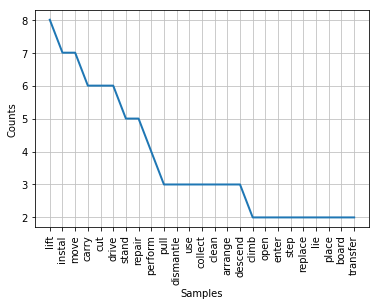

Total count for this dataset is 140


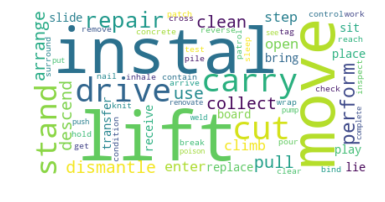



Caught in/between Objects


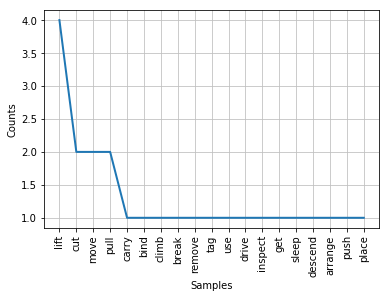

Total count for this category is 25


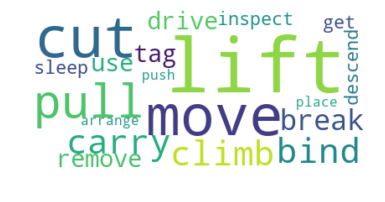

Top 5 activity word and their sentences


lift
====

lift the lifting tray
lifting lug
lifting works using Overhead Travelling Crane
lifting a Concrete Pile Head



cut
===

cutting down trees
cutting the trees



move
====

removing the glass door
moving brick trucks
moving downwards



pull
====

pulling out cages
pulling out the cages



carry
=====

carrying the job of binding Reinforcement Steel Cage


Falls


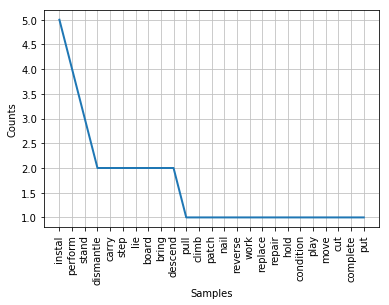

Total count for this category is 42


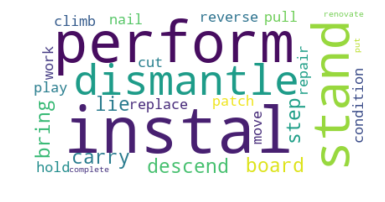

Top 5 activity word and their sentences


instal

installing roof trusses
installing the wall cladding
installing the roof
installing air conditioning pipes
installing water cooling cables



perform

performing cable pulling job
performing floor tiles installation
performing the installation of the working platform
performing the installation



stand
=====

standing on plywood plate
standing on the scaffolds
standing on a wagon



dismantle

dismantling Shear Wall
dismantling the scaffolding



carry
=====

carrying mold installation
carry out binding
carrying out T-Beam


Drowning


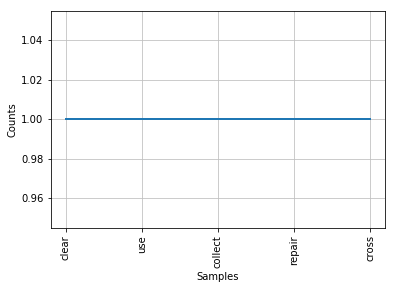

Total count for this category is 5


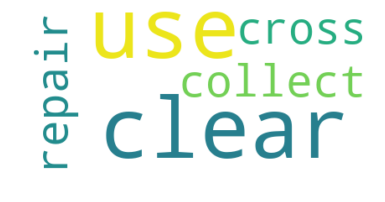

Top 5 activity word and their sentences


clear
=====

clearing work using bulldozer



use
===




collect

collecting water samples



repair

repairing a sand processing machine



cross
=====

crossing the river


Other


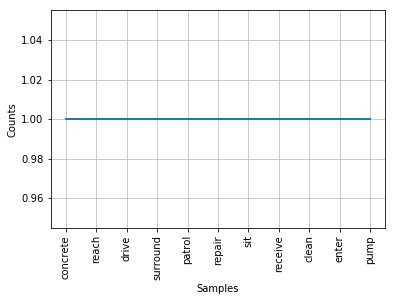

Total count for this category is 11


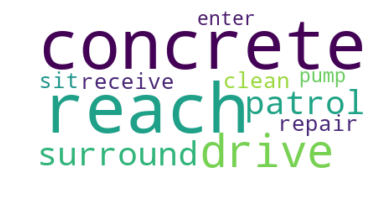

Top 5 activity word and their sentences


concrete

concreting the floor



reach
=====

reaching the control room



drive
=====

driving down a steep path



surround

surrounding earth afterwards



patrol

patroling the plantation


Struck By Moving Objects


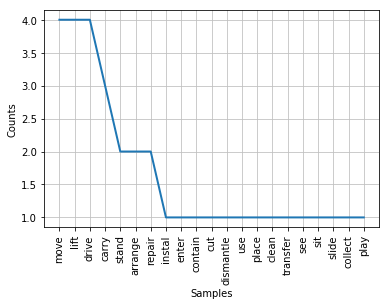

Total count for this category is 35


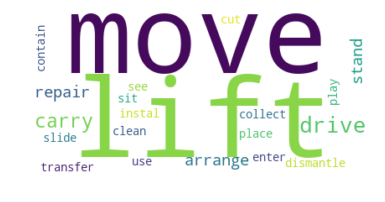

Top 5 activity word and their sentences


move
====

move the box containing foods
moving forklift
moving truck
moving the logs



lift
====

lifting a bundle
lifting a pile
lifting the drain block
lifting a load



drive
=====

driving downhill
driving uphill
driving up the steep road
driving a tractor
driving a tractor carrying earth



carry
=====

carrying road leveling work using steamroller
carrying out visual inspection



stand
=====

standing on the drawbar trailer
standing on the connection


Collapse of object


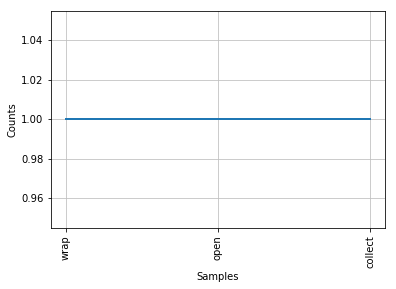

Total count for this category is 3


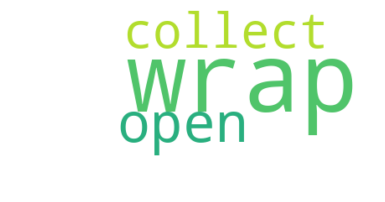

Top 5 activity word and their sentences


wrap
====

wrapping plastic tubing



open
====

opening the mold



collect

collecting cans


Fires and Explosion


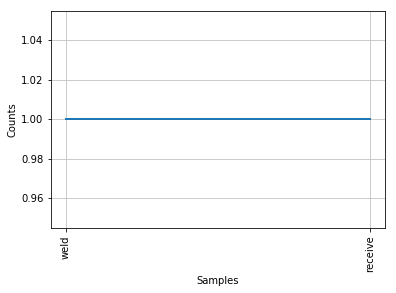

Total count for this category is 2


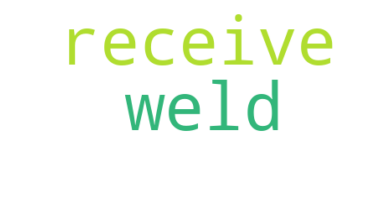

Top 5 activity word and their sentences


weld
====

welding the cover



receive

receiving treatment


Electrocution


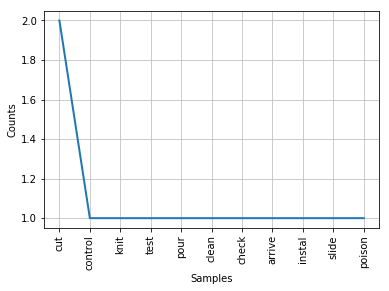

Total count for this category is 12


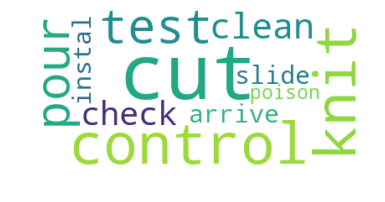

Top 5 activity word and their sentences


cut
===

cutting the oil palm fruit
cutting a cable



control

controlling the traffic



knit
====

knitting the oil palm fruits



test
====

testing the circuit



pour
====

pouring the concrete


Suffocation


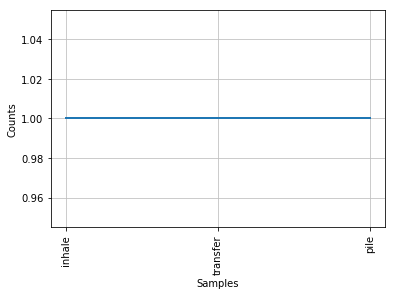

Total count for this category is 3


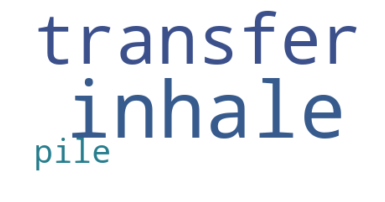

Top 5 activity word and their sentences


inhale

inhaling toxic gas while transfering schedule wastes



transfer




pile
====

piling machine


Exposure to Chemical Substances


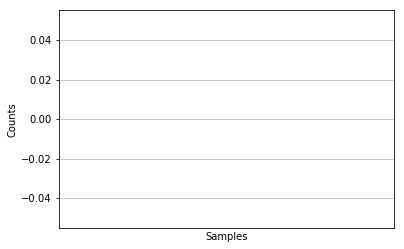

Total count for this category is 0


ValueError: We need at least 1 word to plot a word cloud, got 0.

In [160]:
if ProcessMsiaDataSet:
    chunk_count = 0
    verb_count = 0
    VisualisationAll(MsiaCaseItems)
    for cat in MsiaCategories:
        for chunk1 in cat.ActivityTokensChunk:
            for chunk2 in chunk1:
                if (len(chunk2) >= 1):
                    chunk_count += 1
        for verb1 in cat.ActivityTokensVerb:
            for verb2 in verb1:
                verb_count += len(verb2.split(' '))
        if (len(cat.ActivityTokensVerb) >0):
            Visualisation(cat)
    print("Msia Extraction Chunk Count is " +  str(chunk_count))
    print("Msia Extraction Verb Count is " +  str(verb_count)) 

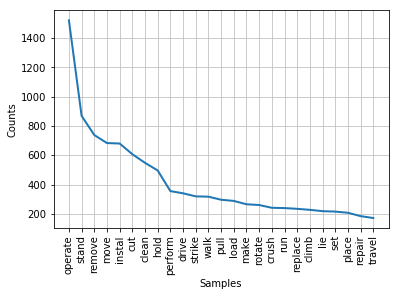

Total count for this dataset is 28780


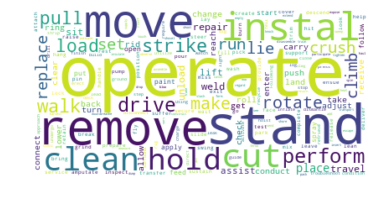



Caught in/between Objects


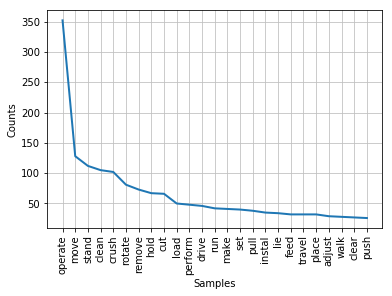

Total count for this category is 3889


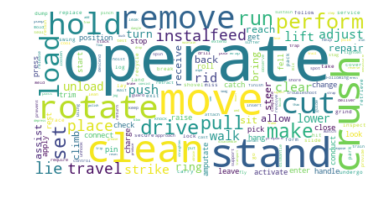

Top 5 activity word and their sentences


operate

operating a rough terrain forklift
operating an asphalt-pulverizing machine
operating a polypropylene filament extruder machine
operating the backhoe
operating a Lavina
operating an unfamiliar stand-up forklift
operating an E30 XL Hyster
operating a scissor lift
operating an aerial lift
operating a CNC lathe



move
====

moving boom section
removing the fifth beam
moving rough-top conveyor
moving tire
moving conveyor belt
moving conveyor belt
moving conveyor
removing safety brackets
moving the boom
moving rollers



stand
=====

standing on a portable ladder adjusting
standing platform
standing in front
standing near the tunnel entrance
standing in the basket
standing at the rear
standing at the front
standing in front
standing in front
standing on the pipe



clean
=====

cleaning photo sensor eyes
cleaning the build-up
cleaning the machine
cleaning the rag
cleaning the idler roll
cleaning rollers
cleaning a plastic grinding machine


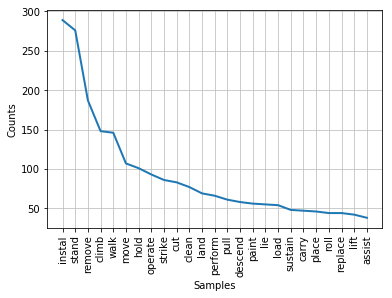

Total count for this category is 5758


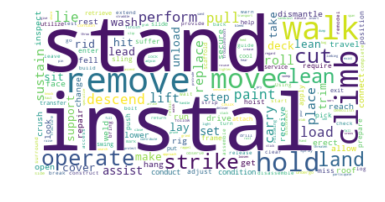

Top 5 activity word and their sentences


instal

installing vinyl sidings
installing roofing felt paper
installing Western Union Signs
installing an advertisement sign
installing the advertisement
installing curbing for the installation
installing fasteners
installing reinforcing bars
installing rigging equipment
install the rolled poly plastic over the existing plastic



stand
=====

standing an A-frame ladder
standing on the corner end
standing on a beam
standing on the skylight
standing atop a rice bin
standing in the bin
standing on unguarded ladder
standing on a FMC Commander
standing on the flatbed trailer
standing on gondola roofs



remove

remove a piece of roofing machinery
removing road construction warning signs
removing a number
removing wall-mounted triangular brackets
removing the almonds
removing a cover
removing flue gas tubes
removing tin roof panels
removing the ladder
removing asbestos containing material



climb
=====

climbing rope
climbing pegs
climbing tower


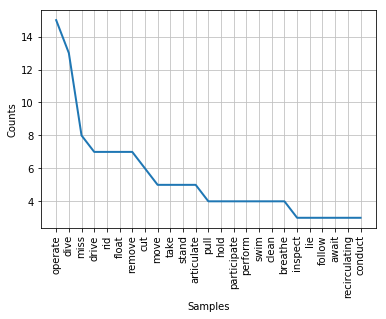

Total count for this category is 291


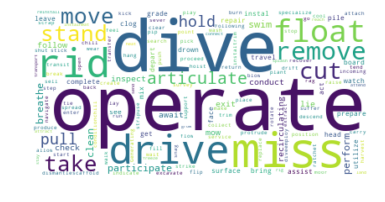

Top 5 activity word and their sentences


operate

operating a Link-Belt Crane
operating the Model Number D9H bulldozer
operating a D-9 dozer stock piling gravel
operating a John Deere Model Number200C LC excavator
operating the machine
operating a backhoe
operating a Yamaha BearTracker all-terrain vehicle
operating a Komatsu PC
operating a backhoe loader
operating a Ford



dive
====

diving operations
diving for sea urchins
diving equipment
diving partner/trainer
diving for sea urchins
diving employing a Huka device
diving equipment
diving helmet
diving helmet
diving underneath a casino barge



miss
====

missing in the afternoon
missing diver
missing diver
missing golf cart
missing a few hours
missing person report
missing after a head count
missing by family



drive
=====

driving a John Deere tractor
driving a Kubota Model Number MX500
driving the tractor
driving under adverse weather conditions
driving on the road
driving the backhoe
driving on a dirt road



rid
===

riding a 

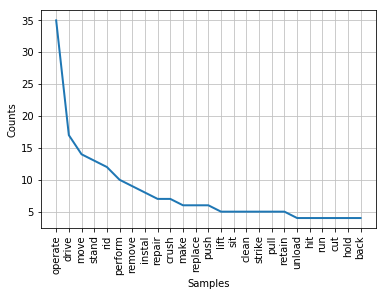

Total count for this category is 430


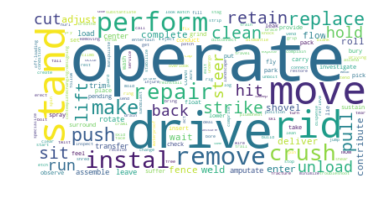

Top 5 activity word and their sentences


operate

operating a standup forklift
operating a backhoe
operating an electric forklift
operating a bobcat loader
operating an industrial truck
operating a box temper furnace
operating at the bottom
operating a rough terrain forklift
operating a 40-ton Lorain crane
operating other scissor lifts



drive
=====

driving the lift
driving a forklift
driving a vehicle
driving Employee
driving the lift
driving a REDI-LIFT Hydraulic truck crane
driving the aerial lift truck
driving the ATV
driving a Terex
driving a Toyota sit



move
====

moving pistons
moving a two-wheeled Kelco blasting pot
removing a hose
moving the cart
removing the nut
removing the wood material
moving the line
removing the defective component Employee
removing chains
removing a screw-on end cap nitrogen



stand
=====

standing on the skid
standing on the ground
standing on the side of the cooling table
standing position
standing near the end
standing on a stick
standing in fr

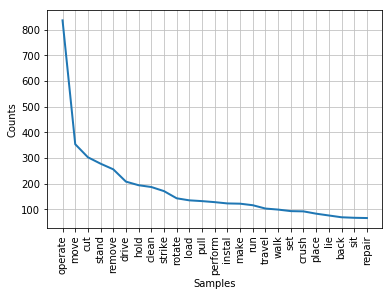

Total count for this category is 11230


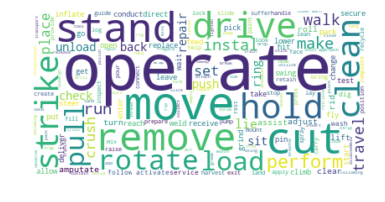

Top 5 activity word and their sentences


operate

operating a beet harvesting machine
operating a wire rope winding machine
operating the wire rope winder without wearing face protection
operating an Oakley
operating a Golf
operate a sandblasting pot
operating above the revolutions-per-minute
operating a Raymond Model Number
operating pallet jacks
operating an aerial lift



move
====

moving cans
moving components
remove the welding splatter
removing jet fuel emissions
removing an item
moving the cart
removing an air hose
move out of the way of the falling branch
removing mechanical equipment
moving part



cut
===

cutting the seal
cutting a third piece
cutting an aluminum sheet
cutting a metal railing
cutting through a knot
cutting torch
cutting down a eucalyptus tree
cutting the top
cutting the beam
cutting a piece



stand
=====

standing in front
standing in the front
standing in front
standing on the elevated lift platform
standing by a tree
standing near the handler
standing i

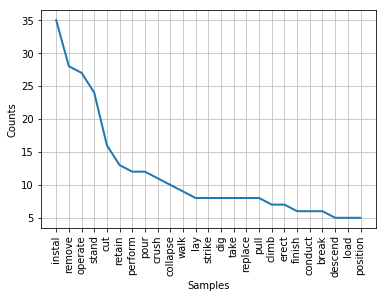

Total count for this category is 732


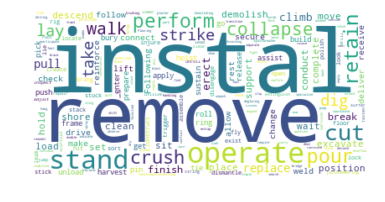

Top 5 activity word and their sentences


instal

installing the first stage
installing the advertising display
installing equipment
installing control
installing purlins
installing steel
installing a concrete form
installing the wall
installing guardrails
installing the last section



remove

removing branch cuttings
removing the old tile
removing old adhesive
removing the roof
removing a temporary wall
removing the top track
removing steel roofing panels
removing roof panel
removing the panel
removing a transmission



operate

operating the forklift
operating the forklift
operating an Eagle
operating a bull float
operating a backhoe
operating a front loader
operating a band saw
operating a skid-steer tractor
operating a Fraco
operating a VERSACRANE Model Number TC36000 crane



stand
=====

standing on an epoxy-coated dowel
standing on an extension ladder
standing on the front
standing on this section
standing on the roof
standing on a 1-inch by 4-inch catwalk
standing on top
stand

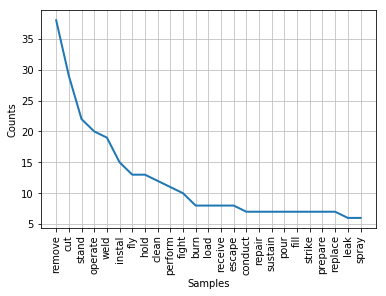

Total count for this category is 794


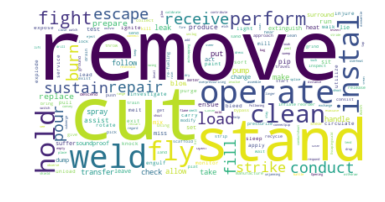

Top 5 activity word and their sentences


remove

removing a custom
removing rock gravel
removing the pipe stem
removing the nozzle
removing Accelerator P
removing the flange
removing the mill access doors
removing the door
removing the kinks
removing cores



cut
===

cutting torch
cutting grinding
cutting area
cutting area
cutting torch
cutting the device with a cutting torch
cutting torch
cutting torch
cutting torch
cutting torch



stand
=====

standing in an excavation
standing in the immediate area
standing on a platform
standing with the upper portion
standing at the rear
standing at the top
standing on the top edge
standing on planks
standing on the fourth floor landing
standing near the door



operate

operating a Maren model
operating the air valve
operating the choke
operating a vacuum truck
operating procedures
operating a blender
operating presses
operating the electronic firing
operating a gasoline
operating a ditching machine



weld
====

welding a shaft
welding torch


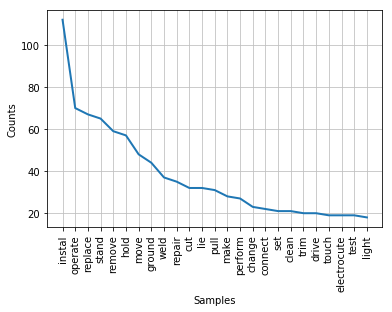

Total count for this category is 2296


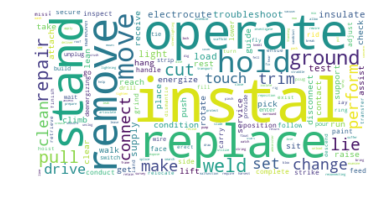

Top 5 activity word and their sentences


instal

installing a new light fixture
install metal sub-flooring
installing all dielectric self-supporting fiber-optic cable
installing additional cross braces
installing supporting braces
installing a thermostat line
installing a central air conditioner
installing an electric pole
installing an air conditioning unit
installing equipment



operate

operating the sandblasting equipment
operating a Bliss OBI
operating an asphalt roller
operating the asphalt roller
operating a Bobcat
operating an overhead crane
operating a tug
operating a pile driver
operating a soil auger
operating the auger



replace

replacing the rubber gasket
replacing the guide
replacing some poles
replacing the cover
replacing the ends
replacing light bulbs
replacing the ballast
replacing a ballast
replacing a ballast
replacing a power breaker cover



stand
=====

standing at the end
standing behind Employee
standing on a metal ventilation duct
standing on the shoulder


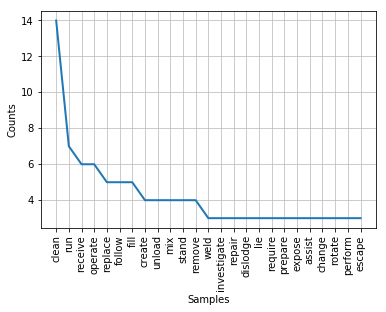

Total count for this category is 276


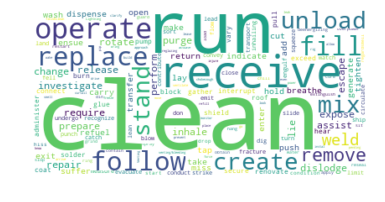

Top 5 activity word and their sentences


clean
=====

cleaning the HVAC system
cleaning up the leaking oil
cleaning up the leaking oil
cleaning equipment
cleaning dust
cleaning the Liebert air conditioning units
cleaning up from the evening meal
cleaning technician
cleaning tech
cleaning up the spill



run
===

running for cover
running water
running water
running off the sides
running on the mill
running polyvinyl chloride
running a piece



receive

receiving pipes
receiving dock attendant
receiving attendant
receiving attendant
receiving gas
receiving training



operate

operating gas forklifts
operating the main control device handles
operating each mixer
operating extruding
operating specifications
operating a LYCOFIT Model Number
operating a Caterpillar D-8 bulldozer
operating a manual choke
operating a Vac-U-Vator vaculator



replace

replacing a solenoid valve
replacing a valve
replacing empty EtO cylinders
replacing a sump pump
replacing an inoperative valve


Exposure to 

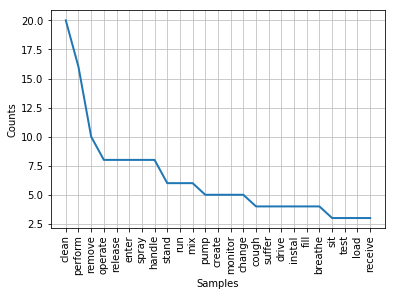

Total count for this category is 445


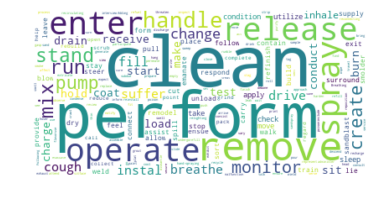

Top 5 activity word and their sentences


clean
=====

cleaning fluids
cleaning the floors
cleaning concrete
cleaning employee
cleaning the butcher block area
cleaning up a stadium
cleaning supplies
cleaning the lavatories
cleaning chemical
cleaning chemicals



perform

performing a fire watch
performing all maintenance
performing fluoride tests
performing mold inspections
performing routine maintenance
perform any monitoring
performing janitorial duties
performing the necessary steps
performing a routine task
performing a chemical transfer



remove

removing pool paint
remove the old coating
removing the hose
removing an I-beam
removing paint
removing a resin pin
removing liquid trichloroethylene
remove a cleaning system
removing stains
removing carpet



operate

operating industrial trucks
operating in the warehouse
operating this gasoline
operating manual specifies operating limits
operating a tanker truck
operating in the enclosed garage
operating a paper coating machine
operati

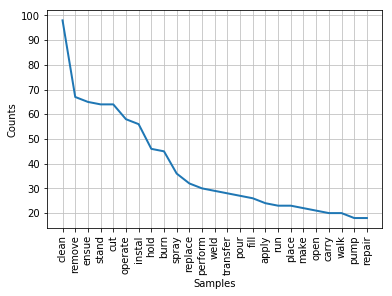

Total count for this category is 2639


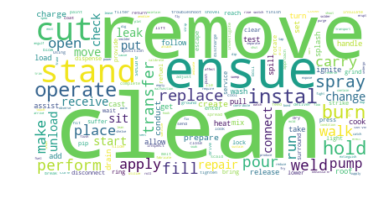

Top 5 activity word and their sentences


clean
=====

cleaning the interior
cleaning gypsum
cleaning the interior
cleaning the tank Employee
cleaning with acetone
cleaning a separation tank
cleaning with a rag
cleaning out metal shavings
cleaning ground aluminum particles
cleaning miscellaneous material



remove

removing material
removing rubber hoses
removing a bearing
removing the filter canisters
removing a manufactured part
removing locking pins
removing a temporary electric service
removing racks
removing the second main fuse
removing the pump



ensue
=====

ensuing electric arc
ensuing electric arc
ensuing fire
ensuing electric arc
ensuing electric arc
ensuing electric arc
ensuing electric arc
ensuing electric arc
ensuing fire
ensuing electric arc



stand
=====

standing in front
standing by the suction valve
standing by the side
standing on south side
standing north
standing near the unit
standing at the base
standing on the ground
standing near the rear driver
standing out

In [144]:
if ProcessOshaDataSet:
    chunk_count = 0
    verb_count = 0
    VisualisationAll(OshaCaseItems)
    for cat in OshaCategories:
        for chunk1 in cat.ActivityTokensChunk:
            for chunk2 in chunk1:
                if (len(chunk2) >= 1):
                    chunk_count += 1
        for verb1 in cat.ActivityTokensVerb:
            for verb2 in verb1:
                verb_count += len(verb2.split(' '))
        if (len(cat.ActivityTokensVerb) >0):
            Visualisation(cat)
    print("Osha Extraction Chunk Count is " +  str(chunk_count))
    print("Osha Extraction Verb Count is " +  str(verb_count))       

# Output to excel file with new additional columns for activity and activity chunks

In [161]:
#Write to excel with the additional columns for activity verb 
if ProcessMsiaDataSet:
    NewColumn1 = []
    NewColumn2 = []
    for item in MsiaCaseItems:
        if item.ActivityTokensVerb == []:
            NewColumn1.append("")
            NewColumn2.append("")
        else:
            NewColumn1.append(','.join(item.ActivityTokensVerb))
            NewColumn2.append(','.join(item.ActivityTokensChunk))
    MsiaCasesDF.eval("ActivityVerb = @NewColumn1", inplace=True)
    MsiaCasesDF.eval("ActivityChunk = @NewColumn2", inplace=True)
    WriteToExcel('MsiaWithActivity.xlsx',OshaCasesDF)

if ProcessOshaDataSet:
    NewColumn1 = []
    NewColumn2 = []
    for item in OshaCaseItems:
        if item.ActivityTokensVerb == []:
            NewColumn1.append("")
            NewColumn2.append("")
        else:
            NewColumn1.append(','.join(item.ActivityTokensVerb))
            NewColumn2.append(','.join(item.ActivityTokensChunk))
    OshaCasesDF.eval("ActivityVerb = @NewColumn1", inplace=True)
    OshaCasesDF.eval("ActivityChunk = @NewColumn2", inplace=True)
    WriteToExcel('OshaWithActivity.xlsx',OshaCasesDF)


# Notes and Observation: 
- For the Msia dataset which is used as training dataset, the summary columns are mostly made up of complete grammatically sound sentences and thus the regular expression parser method is chosen to extract the activity phrases.

- For Msia dataset there's only 240 records, so we have a rather small dataset for training. Also, Msia dataset only have Summary column whereas Osha has a more detailed Descrition column.

- For Osha, we were able to extract out 29502 activities. This could mean for each column more than 1 activity (most likely a series of activity) taking place prior to the accident since total records in the dataset is about 28780.

- In some sentences, for example, the actually activity is "handling maintenance work", thus the actual activity is maintenance work but because the regular expression parser is designed to extract the verb activity resulted in "handling" being captured instead of "maintaining" and results in a less than accurate description of the activity extracted from the dataset.

- Further improvements: Some of the activities captured are actually describing the cause of the incident, thus in order to get a more accurate text mining on activities, prior domain knowledge on what is considered cause and what is activities need to be incorporated.